# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [278]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")


In [279]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [280]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


In [281]:
#display all columns in dataframe
pd.set_option('display.max_columns',None)

### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

#df = pd.read_parquet(r'trip_records\2023-1.parquet')
#df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'trip_records\\2023-1.parquet'

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [283]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir(r'C:\Users\Kanak\Desktop\EDANYC\trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        monthly_data = pd.read_parquet(file_path)
        print(f"Loaded File {monthly_data.shape}") # check if all 12 files are getting laoded 1 by 1
        monthly_data.tpep_pickup_datetime = pd.to_datetime(monthly_data.tpep_pickup_datetime)
        monthly_data['Pickup_date'] = monthly_data.tpep_pickup_datetime.dt.date # Extract Date  
        monthly_data['Pickup_day'] = monthly_data.tpep_pickup_datetime.dt.day   # Extract Day
        monthly_data['Pickup_hour'] = monthly_data.tpep_pickup_datetime.dt.hour # Extract Hour of day 
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for day in range(32): # Max days could be 31
            Day_data =pd.DataFrame()
            # Iterate through each hour of the selected date
            for hour in range(24):
                hourly_data = monthly_data[( monthly_data.Pickup_day == day) & ( monthly_data.Pickup_hour == hour) ] #filter on day and hour
                # Sample 5% of the hourly data randomly
                sample = hourly_data.sample(frac=0.05,random_state=42) # 5% and random state
                # add data of this hour to the dataframe
                sampled_data = pd.concat([sampled_data,sample])
        # Concatenate the sampled data of all the dates to a single dataframe
        #df = # we initialised this empty DF earlier
        df = pd.concat([df,sampled_data])
        print(f" Processed File: {file_name} , monthly Data shape {monthly_data.shape} DataFrame {df.shape}")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Loaded File (3041714, 19)
 Processed File: 2023-1.parquet , monthly Data shape (3041714, 22) DataFrame (152087, 22)
Loaded File (3485185, 19)
 Processed File: 2023-10.parquet , monthly Data shape (3485185, 22) DataFrame (326341, 23)
Loaded File (3302857, 19)
 Processed File: 2023-11.parquet , monthly Data shape (3302857, 22) DataFrame (491474, 23)
Loaded File (3333925, 19)
 Processed File: 2023-12.parquet , monthly Data shape (3333925, 22) DataFrame (658183, 23)
Loaded File (3374086, 19)
 Processed File: 2023-2.parquet , monthly Data shape (3374086, 22) DataFrame (826889, 23)
Loaded File (3275796, 19)
 Processed File: 2023-3.parquet , monthly Data shape (3275796, 22) DataFrame (990675, 23)
Loaded File (2792901, 19)
 Processed File: 2023-4.parquet , monthly Data shape (2792901, 22) DataFrame (1130317, 23)
Loaded File (2889185, 19)
 Processed File: 2023-5.parquet , monthly Data shape (2889185, 22) DataFrame (1274780, 23)
Loaded File (3258261, 19)
 Processed File: 2023-6.parquet , monthly

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
df.shape # check shape of data 

**Observation by** <font color = green>Suyash Nagar</font> <br>
There are 18 Million plus records 

In [284]:
# Store the df in csv/parquet
df.to_parquet(r'C:\Users\Kanak\Desktop\EDANYC\Sampled_data_Suyash.parquet')


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [285]:
# Load the new data file
df=pd.read_parquet(r'C:\Users\Kanak\Desktop\EDANYC\Sampled_data_Suyash.parquet')
print(df.shape )
df= df.sample(n=300000,random_state=42)
df.shape

(1896420, 23)


(300000, 23)

In [286]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1328753         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
156897          2  2023-11-02 12:12:16   2023-11-02 12:20:04              1.0   
1042065         2  2023-10-11 07:04:36   2023-10-11 08:07:26              2.0   
1006144         2  2023-12-09 14:07:29   2023-12-09 15:15:16              2.0   
3246250         1  2023-11-09 10:08:16   2023-11-09 10:41:41              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1328753           6.30         1.0                  N           140   
156897            1.38         1.0                  N           239   
1042065          21.34         1.0                  N           132   
1006144          22.04         2.0                  N           132   
3246250           9.80         NaN               None           164   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
1328753            87             1         30.3    2.5      0.5        7.00   
156897             43             2          9.3    0.0      0.5        0.00   
1042065            14             1         88.4    0.0      0.5        5.00   
1006144           142             1         70.0    0.0      0.5       24.28   
3246250           138             0         45.7    5.0      0.5        8.50   

         tolls_amount  improvement_surcharge  total_amount  \
1328753          0.00                    1.0         41.30   
156897           0.00                    1.0         13.30   
1042065          0.00                    1.0         96.65   
1006144          6.94                    1.0        106.97   
3246250          6.94                    1.0         70.14   

         congestion_surcharge  airport_fee Pickup_date  Pickup_day  \
1328753                   2.5          NaN  2023-02-14          14   
156897                    2.5          NaN  2023-11-02           2   
1042065                   0.0          NaN  2023-10-11          11   
1006144                   2.5          NaN  2023-12-09           9   
3246250                   NaN          NaN  2023-11-09           9   

         Pickup_hour  Airport_fee  
1328753            8         0.00  
156897            12         0.00  
1042065            7         1.75  
1006144           14         1.75  
3246250           10          NaN

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 1328753 to 3042229
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               300000 non-null  int64         
 1   tpep_pickup_datetime   300000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  300000 non-null  datetime64[us]
 3   passenger_count        289689 non-null  float64       
 4   trip_distance          300000 non-null  float64       
 5   RatecodeID             289689 non-null  float64       
 6   store_and_fwd_flag     289689 non-null  object        
 7   PULocationID           300000 non-null  int64         
 8   DOLocationID           300000 non-null  int64         
 9   payment_type           300000 non-null  int64         
 10  fare_amount            300000 non-null  float64       
 11  extra                  300000 non-null  float64       
 12  mta_tax                300000 non-null  fl

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [288]:
# Fix the index and drop any columns that are not needed

df.reset_index(drop=True,inplace=True)

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               300000 non-null  int64         
 1   tpep_pickup_datetime   300000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  300000 non-null  datetime64[us]
 3   passenger_count        289689 non-null  float64       
 4   trip_distance          300000 non-null  float64       
 5   RatecodeID             289689 non-null  float64       
 6   store_and_fwd_flag     289689 non-null  object        
 7   PULocationID           300000 non-null  int64         
 8   DOLocationID           300000 non-null  int64         
 9   payment_type           300000 non-null  int64         
 10  fare_amount            300000 non-null  float64       
 11  extra                  300000 non-null  float64       
 12  mta_tax                300000 non-null  floa

**Observation by** <font color = green>Suyash Nagar</font> <br>
Index Reset completed, since analysis just started so not droping any columns 

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [290]:
# Combine the two airport fee columns
df.airport_fee = df.airport_fee.fillna(0) + df.Airport_fee.fillna(0) #Merge both columns by adding and replacing nulls with 0
df.drop('Airport_fee',axis=1,inplace=True) # Drop column 'Airport_fee'
df.head(2)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
1         2  2023-11-02 12:12:16   2023-11-02 12:20:04              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           6.30         1.0                  N           140            87   
1           1.38         1.0                  N           239            43   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5         7.0           0.0   
1             2          9.3    0.0      0.5         0.0           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0          41.3                   2.5          0.0   
1                    1.0          13.3                   2.5          0.0   

  Pickup_date  Pickup_day  Pickup_hour  
0  2023-02-14          14            8  
1  2023-11-02           2           12

**Observation by** <font color = green>Suyash Nagar</font> <br>
- Combined both the columns by replaceing null and adding  
- Dropped redundant column Airport_fee

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [291]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour'],
      dtype='object')

In [292]:
# check where values of fare amount are negative
print(f"Number where values of fare amount are negative:  {df.fare_amount.lt(0).sum()}")


Number where values of fare amount are negative:  0


**Observation by** <font color = green>Suyash Nagar</font> <br>
- There are no negative value for fare amount as shown above

Did you notice something different in the `RatecodeID` column for above records?

In [293]:
# Analyse RatecodeID for the negative fare amounts

df.groupby('RatecodeID')['fare_amount'].describe()


count        mean        std  min    25%    50%     75%     max
RatecodeID                                                                    
1.0         273794.0   16.846150  12.588678  0.0   9.30  12.80   19.80   786.3
2.0          11198.0   69.942588   1.975538  0.0  70.00  70.00   70.00    70.0
3.0            957.0   87.344619  29.603208  0.0  81.10  89.50   98.60   256.8
4.0            543.0  112.032597  89.911510  0.0  62.15  95.40  141.25  1375.0
5.0           1548.0   76.487810  65.225517  0.0  31.50  78.15   90.00   999.0
6.0              1.0    2.500000        NaN  2.5   2.50   2.50    2.50     2.5
99.0          1648.0   33.018841  17.927610  0.0  20.50  29.50   41.50   425.0

**Observation by** <font color = green>Suyash Nagar</font> <br>
- There are no negative value for fare amount as shown above
- However, RateCodeID 99 is not defined in data dicitionary 

In [294]:
# Find which columns have negative values
negative_value_columns = [cols for cols in 
                            df.select_dtypes(include=[np.number]).columns 
                            if (df[cols].min() < 0)]
print(f" Columns in NYC Taxi DataFrame with negative value are : {negative_value_columns}")

 Columns in NYC Taxi DataFrame with negative value are : ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


**Observation by** <font color = green>Suyash Nagar</font> <br>
- 'extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee' : columns with negative values

In [295]:
df[df[negative_value_columns].lt(0).any(axis=1)].head(10)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
9847           2  2023-05-31 14:52:23   2023-05-31 15:54:56              2.0   
60450          2  2023-01-17 15:03:44   2023-01-17 15:36:28              1.0   
63943          2  2023-07-03 14:46:17   2023-07-03 15:03:59              1.0   
105441         2  2023-07-29 03:47:56   2023-07-29 03:48:34              4.0   
106981         2  2023-10-27 14:51:03   2023-10-27 14:51:11              1.0   
111568         2  2023-07-27 17:56:27   2023-07-27 18:00:12              1.0   
128418         2  2023-11-06 14:30:56   2023-11-06 15:18:30              1.0   
165300         2  2023-01-02 05:12:19   2023-01-02 05:41:45              1.0   
176387         2  2023-07-11 14:13:25   2023-07-11 15:24:35              1.0   
239674         2  2023-03-20 12:10:40   2023-03-20 13:03:14              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
9847            17.37         2.0                  N           132   
60450            4.12         1.0                  N           239   
63943            2.58         1.0                  N           163   
105441           0.00         5.0                  N            79   
106981           0.00         1.0                  N           265   
111568           0.66         1.0                  N           113   
128418          16.92         2.0                  N           170   
165300          17.07         3.0                  N           142   
176387           9.50         1.0                  N           181   
239674          16.11         2.0                  N           132   

        DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
9847             132             2          0.0    0.0     -0.5         0.0   
60450            168             2          0.0    0.0     -0.5         0.0   
63943            238             2          0.0    0.0     -0.5         0.0   
105441            79             4          0.0    0.0      0.0         0.0   
106981           265             2          3.0   -2.5      0.0         0.0   
111568           234             2          0.0    0.0     -0.5         0.0   
128418           132             2          0.0    0.0     -0.5         0.0   
165300             1             2          0.0    0.0      0.0         0.0   
176387            13             2          0.0    0.0     -0.5         0.0   
239674           170             2          0.0    0.0     -0.5         0.0   

        tolls_amount  improvement_surcharge  total_amount  \
9847             0.0                   -1.0         -5.75   
60450            0.0                   -1.0         -4.00   
63943            0.0                   -1.0         -4.00   
105441           0.0                   -1.0         -3.50   
106981           0.0                    1.0          4.00   
111568           0.0                   -1.0         -4.00   
128418           0.0                   -1.0         -4.00   
165300           0.0                   -1.0         -1.00   
176387           0.0                   -1.0         -4.00   
239674           0.0                   -1.0         -5.25   

        congestion_surcharge  airport_fee Pickup_date  Pickup_day  Pickup_hour  
9847                    -2.5        -1.75  2023-05-31          31           14  
60450                   -2.5         0.00  2023-01-17          17           15  
63943                   -2.5         0.00  2023-07-03           3           14  
105441                  -2.5         0.00  2023-07-29          29            3  
106981                   0.0         0.00  2023-10-27          27           14  
111568                  -2.5         0.00  2023-07-27          27           17  
128418                  -2.5         0.00  2023-11-06           6           14  
165300                   0.0         0.00  2023-01-02           2            5  
176387                  -2.5         0.00  2023-07-11          11           14  
2396

In [296]:
# fix these negative values
#print number of negative value in each column
for cols in negative_value_columns: 
    print(f" column '{cols}' has {df[cols].lt(0).sum()} ")

#convert negative value to positive using abs 
df[negative_value_columns] = df[negative_value_columns].abs()

#print number of negative value in each column, now for each column it should return 0
print("----------------------After Cleansing--------------------------------")
for cols in negative_value_columns: 
    print(f" column '{cols}' has {df[cols].lt(0).sum()} ")

 column 'extra' has 1 
 column 'mta_tax' has 8 
 column 'improvement_surcharge' has 10 
 column 'total_amount' has 10 
 column 'congestion_surcharge' has 9 
 column 'airport_fee' has 2 
----------------------After Cleansing--------------------------------
 column 'extra' has 0 
 column 'mta_tax' has 0 
 column 'improvement_surcharge' has 0 
 column 'total_amount' has 0 
 column 'congestion_surcharge' has 0 
 column 'airport_fee' has 0 


**Observation by** <font color = green>Suyash Nagar</font> <br>
- 'extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee' : columns with negative values have been converted to positives 
- There are no more negative values

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [297]:
# Find the proportion of missing values in each column

print(f" Below are the proportion of missing values in each columns\n\n {np.round((df.isnull().sum()/df.shape[0]*100),2)}")

 Below are the proportion of missing values in each columns

 VendorID                 0.00
tpep_pickup_datetime     0.00
tpep_dropoff_datetime    0.00
passenger_count          3.44
trip_distance            0.00
RatecodeID               3.44
store_and_fwd_flag       3.44
PULocationID             0.00
DOLocationID             0.00
payment_type             0.00
fare_amount              0.00
extra                    0.00
mta_tax                  0.00
tip_amount               0.00
tolls_amount             0.00
improvement_surcharge    0.00
total_amount             0.00
congestion_surcharge     3.44
airport_fee              0.00
Pickup_date              0.00
Pickup_day               0.00
Pickup_hour              0.00
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [298]:
# Display the rows with null values
null_rows = df[df.isnull().any(axis=1)]
print(f" Number of rows with missing value : {null_rows.shape[0]}")
# Impute NaN values in 'passenger_count'
print(f"Number of missing value in passenger_count column {df.passenger_count.isnull().sum()}")
print(f"Find the mode of passanger_count {df.passenger_count.mode()[0].astype(int)}") 
df.passenger_count.fillna(df.passenger_count.mode()[0].astype(int),inplace=True) #impute as type int since passanger count can not be a decimal
print(f"Number of missing value in passenger_count column after Impute : {df.passenger_count.isnull().sum()}")


 Number of rows with missing value : 10311
Number of missing value in passenger_count column 10311
Find the mode of passanger_count 1
Number of missing value in passenger_count column after Impute : 0


Did you find zeroes in passenger_count? Handle these.

In [299]:
print(f"Passanger count by trip taken  :{df.passenger_count.value_counts()}")
df[df.passenger_count ==0]
print(f"Count of '0' in passenger_count column  :{df[df.passenger_count==0].shape[0]}")
df.passenger_count.replace(0,df.passenger_count.mode()[0],inplace=True)
print(f"Count of '0' in passenger_count column after Impute :{df[df.passenger_count==0].shape[0]}") #this should return 0

Passanger count by trip taken  :passenger_count
1.0    228440
2.0     43615
3.0     10854
4.0      6017
0.0      4743
5.0      3758
6.0      2571
9.0         1
8.0         1
Name: count, dtype: int64
Count of '0' in passenger_count column  :4743
Count of '0' in passenger_count column after Impute :0


**Observation by** <font color = green>Suyash Nagar</font> <br>
- Same amount of rows are having null i.e. 10311 for passanger_count , RatecodeID, store_and_fwd_flag and congestion_surcharge
- Imputed passanger_count count with mode value of type int as passanger is whole number
- There are 4K plus records with passanger count as 0 those are replaced with mode value that is 1

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [300]:
# Fix missing values in 'RatecodeID'
print(f" Diffrent RatecodeID presnt in data \n\n{df.RatecodeID.value_counts()}")
print(f"Number of nulls in column RatecodeID: {df.RatecodeID.isnull().sum()}")
df.RatecodeID.fillna(df.RatecodeID.mode()[0],inplace=True)
print(f"Number of nulls in column RatecodeID after Impute: {df.RatecodeID.isnull().sum()}")
print(f"99.0 is not defined in data dictonary : {df[df.RatecodeID == 99].shape[0]}")
df.RatecodeID.replace(99,df.RatecodeID.mode()[0],inplace=True)
print(f"99.0 after replace with most occuring value: {df[df.RatecodeID == 99].shape[0]}")


 Diffrent RatecodeID presnt in data 

RatecodeID
1.0     273794
2.0      11198
99.0      1648
5.0       1548
3.0        957
4.0        543
6.0          1
Name: count, dtype: int64
Number of nulls in column RatecodeID: 10311
Number of nulls in column RatecodeID after Impute: 0
99.0 is not defined in data dictonary : 1648
99.0 after replace with most occuring value: 0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [301]:
# handle null values in congestion_surcharge
#sampled_data[sampled_data.congestion_surcharge.isnull()].head(5)
print(f"Number of nulls in column congestion_surcharge: {df.congestion_surcharge.isnull().sum()}")
#Replace nulls with mode
df['congestion_surcharge'].fillna(0,inplace=True)
print(f"Number of nulls in column congestion_surcharge after imputation: {df.congestion_surcharge.isnull().sum()}")



Number of nulls in column congestion_surcharge: 10311
Number of nulls in column congestion_surcharge after imputation: 0


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [302]:
# Handle any remaining missing values
print(f" Below are the proportion of missing values in each columns\n\n {np.round((df.isnull().sum()/df.shape[0]*100),2)}")

df.isnull().sum() #no missing values
#Impute store_and_fwd_flag with mode
print (f"Number of nulls in column store_and_fwd_flag: {df.store_and_fwd_flag.isnull().sum()}")
sampled_data['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0],inplace=True)
print (f"Number of nulls in column store_and_fwd_flag after imputation: {df.store_and_fwd_flag.isnull().sum()}")
print(f" Below are the proportion of missing values in each columns\n\n{np.round((df.isnull().sum()/df.shape[0]*100),2)}")


 Below are the proportion of missing values in each columns

 VendorID                 0.00
tpep_pickup_datetime     0.00
tpep_dropoff_datetime    0.00
passenger_count          0.00
trip_distance            0.00
RatecodeID               0.00
store_and_fwd_flag       3.44
PULocationID             0.00
DOLocationID             0.00
payment_type             0.00
fare_amount              0.00
extra                    0.00
mta_tax                  0.00
tip_amount               0.00
tolls_amount             0.00
improvement_surcharge    0.00
total_amount             0.00
congestion_surcharge     0.00
airport_fee              0.00
Pickup_date              0.00
Pickup_day               0.00
Pickup_hour              0.00
dtype: float64
Number of nulls in column store_and_fwd_flag: 10311
Number of nulls in column store_and_fwd_flag after imputation: 10311
 Below are the proportion of missing values in each columns

VendorID                 0.00
tpep_pickup_datetime     0.00
tpep_dropoff_datetime

**Observation by** <font color = green>Suyash Nagar</font> <br>
- All missing values in df data frame has been taken care of 

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [303]:
# Describe the data and check if there are any potential outliers present
print(f"Describe NYC data frame\n\n {df.describe()}")
# Check for potential out of place values in various columns
# Check for potential out of place values in various columns
print("-------------------------Potential Outliers----------------")
outlier_df = pd.DataFrame()
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25) #25th percentile
    Q3 = df[col].quantile(0.75) #75th percentile
    IQR = Q3 - Q1                  #Interquartile range
    lower_bound  = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        outlier_df = pd.concat([outlier_df, outliers])
        print(f"Column: {col} has {outliers.shape[0]} potential outliers")
# Remove duplicate outlier rows (some rows may be outliers in multiple columns)
outlier_df.drop_duplicates(inplace=True)
outlier_df


Describe NYC data frame

             VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  300000.000000                      300000                      300000   
mean        1.732383  2023-07-02 21:40:15.857430  2023-07-02 21:57:35.878186   
min         1.000000         2008-12-31 23:11:10         2009-01-01 00:13:17   
25%         1.000000  2023-04-02 16:36:06.250000  2023-04-02 16:58:41.750000   
50%         2.000000         2023-06-27 14:20:58  2023-06-27 14:40:56.500000   
75%         2.000000  2023-10-06 20:21:46.750000  2023-10-06 20:38:07.750000   
max         6.000000         2023-12-31 23:51:49         2024-01-01 00:03:27   
std         0.447808                         NaN                         NaN   

       passenger_count  trip_distance     RatecodeID   PULocationID  \
count    300000.000000  300000.000000  300000.000000  300000.000000   
mean          1.370920       3.617442       1.069793     165.020073   
min           1.000000       0.000000   

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3989           6  2023-03-14 18:03:39   2023-03-14 18:03:47              1.0   
5658           6  2023-06-30 14:06:14   2023-06-30 15:06:25              1.0   
7899           6  2023-08-02 18:08:59   2023-08-02 19:08:06              1.0   
16511          6  2023-09-22 16:09:07   2023-09-22 17:09:57              1.0   
19590          6  2023-05-12 05:05:04   2023-05-12 06:05:31              1.0   
...          ...                  ...                   ...              ...   
262803         2  2023-01-26 15:10:27   2023-01-26 15:39:02              1.0   
276568         2  2023-07-17 18:52:20   2023-07-17 19:05:03              1.0   
288120         2  2023-12-13 11:20:24   2023-12-13 11:31:53              1.0   
288240         2  2023-12-07 15:59:19   2023-12-07 16:03:51              1.0   
294985         2  2023-10-22 13:49:16   2023-10-22 14:15:28              1.0   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3989             6.32         1.0               None           265   
5658            14.91         1.0               None           265   
7899            23.45         1.0               None           265   
16511           10.81         1.0               None           265   
19590           15.39         1.0               None           265   
...               ...         ...                ...           ...   
262803           5.74         1.0                  N           138   
276568           4.03         1.0                  N           132   
288120           4.94         1.0                  N           138   
288240           0.70         1.0                  N           148   
294985           6.79         1.0                  N           138   

        DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3989             177             0        49.02    0.0      0.5        0.00   
5658              22             0        49.73    0.0      0.5        0.00   
7899              39             0        83.38    0.0      0.5        0.00   
16511             76             0        52.95    0.0      0.5        0.00   
19590            164             0        42.01    0.0      0.5        0.00   
...              ...           ...          ...    ...      ...         ...   
262803           141             1        31.00    5.0      0.5        8.00   
276568           219             1        19.10    2.5      0.5        5.12   
288120           226             1        21.20    5.0      0.5        0.00   
288240            79             1         6.50    0.0      0.5        2.10   
294985           229             1        32.40    5.0      0.5        1.00   

        tolls_amount  improvement_surcharge  total_amount  \
3989             0.0                    0.3         49.82   
5658             0.0                    0.3         50.53   
7899             0.0                    0.3         84.18   
16511            0.0                    0.3         53.75   
19590            0.0                    0.3         42.81   
...              ...                    ...           ...   
262803           0.0                    1.0         49.25   
276568           0.0                    1.0         32.47   
288120           0.0                    1.0         31.95   
288240           0.0                    1.0         14.35   
294985           0.0                    1.0         44.15   

        congestion_surcharge  airport_fee Pickup_date  Pickup_day  Pickup_hour  
3989                     0.0         0.00  2023-03-14          14           18  
5658                     0.0         0.00  2023-06-30          30           14  
7899                     0.0         0.00  2023-08-02           2           18  
16511                    0.0         0.00  2023-09-22          22           16  
19590                    0.0         0.00  2023-05-12          12            5  
...                      ...          

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [ ]:
df.columns

In [304]:
# remove passenger_count > 6
print(f" Passanger counts\n{df.passenger_count.value_counts()}")
print(f"Passanger counts greater than six :  {df[df.passenger_count>6].shape[0]}")
df=df[(df.passenger_count <= 6)] #Keep records < 6
print(f"Passanger counts greater than six after dropping :  {df[df.passenger_count>6].shape[0]}")

 Passanger counts
passenger_count
1.0    233183
2.0     43615
3.0     10854
4.0      6017
5.0      3758
6.0      2571
9.0         1
8.0         1
Name: count, dtype: int64
Passanger counts greater than six :  2
Passanger counts greater than six after dropping :  0


In [305]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour'],
      dtype='object')

In [306]:
#Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300

print(f"Number of rows with trip_distance nearly 0 that is 0.1 and fare_amount > 300 after removal: {df[(df.trip_distance < 0.1) & (df.fare_amount > 300)].shape[0]}")
df = df[~((df.trip_distance < 0.1) & (df.fare_amount > 300))] #remove trip_distance nearly 0 and fare_amount > 300
print(f"Number of rows with trip_distance nearly 0 and fare_amount > 300 after removal: {df[(df.trip_distance < 0.1) & (df.fare_amount > 300)].shape[0]}")

Number of rows with trip_distance nearly 0 that is 0.1 and fare_amount > 300 after removal: 7
Number of rows with trip_distance nearly 0 and fare_amount > 300 after removal: 0


In [307]:
#Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)

print(f"Number of rows with trip_distance = 0, fare_amount = 0 and different pickup and dropoff zones: {df[(df.trip_distance == 0) & (df.fare_amount == 0) & (df.PULocationID != df.DOLocationID)].shape[0]}")
df = df[~((df.trip_distance == 0) & (df.fare_amount == 0) & (df.PULocationID != df.DOLocationID))] #remove trip_distance = 0, fare_amount = 0 and different pickup and dropoff zones
print(f"Number of rows with trip_distance = 0, fare_amount = 0 and different pickup and dropoff zones after removal: {df[(df.trip_distance == 0) & (df.fare_amount == 0) & (df.PULocationID != df.DOLocationID)].shape[0]}")

Number of rows with trip_distance = 0, fare_amount = 0 and different pickup and dropoff zones: 7
Number of rows with trip_distance = 0, fare_amount = 0 and different pickup and dropoff zones after removal: 0


In [308]:
#Entries where `trip_distance` is more than 250  miles.
print(f"Number of rows with trip_distance > 250 miles: {df[df.trip_distance > 250].shape[0]}")
df = df[df.trip_distance <= 250] #remove trip_distance > 250
print(f"Number of rows with trip_distance > 250 miles after removal: {df[df.trip_distance > 250].shape[0]}")

Number of rows with trip_distance > 250 miles: 7
Number of rows with trip_distance > 250 miles after removal: 0


In [309]:
#Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)
#df[df.payment_type == 0].shape[0]
print(f"Number of rows with payment_type = 0: {df[df.payment_type == 0].shape[0]}")
#print(df[df.payment_type != 0].shape[0])
df = df[df.payment_type != 0] #remove payment_type = 0
print(f"Number of rows with payment_type = 0 after removal: {df[df.payment_type == 0].shape[0]}")
    

Number of rows with payment_type = 0: 10307
Number of rows with payment_type = 0 after removal: 0


In [310]:
print(f"New shape after outlier handling : {df.shape}")

New shape after outlier handling : (289670, 22)


In [311]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour'],
      dtype='object')

In [312]:
# Continue with outlier handling
df.trip_distance.describe()


count    289670.000000
mean          3.441411
std           4.557616
min           0.000000
25%           1.060000
50%           1.780000
75%           3.380000
max         204.860000
Name: trip_distance, dtype: float64

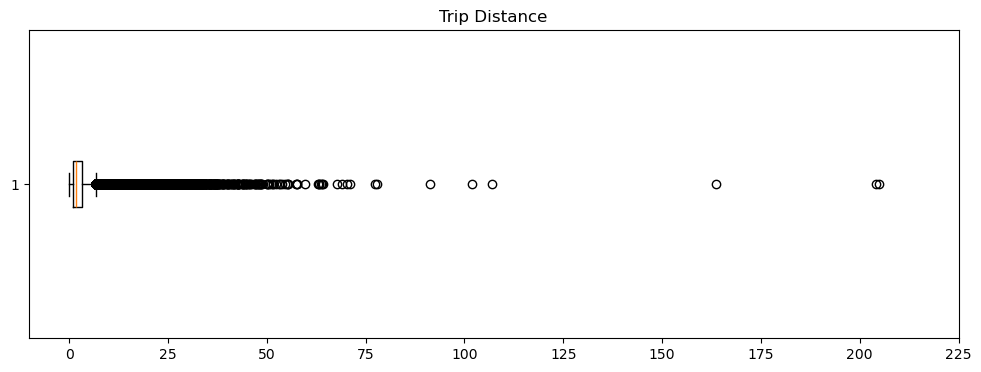

In [313]:
plt.figure(figsize=(12,4))
plt.boxplot(df.trip_distance,vert=False)
plt.title("Trip Distance")
plt.xticks(range(0,250,25))
plt.show()

**Observation by** <font color = green>Suyash Nagar</font> <br>
- Same amount of rows are having null i.e. 10311 for passanger_count , RatecodeID, store_and_fwd_flag and congestion_surcharge
- Mean is around 3.44 and max is around 204
- outlier of more than 100 miles can be dropped 

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289670 entries, 0 to 299999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               289670 non-null  int64         
 1   tpep_pickup_datetime   289670 non-null  datetime64[us]
 2   tpep_dropoff_datetime  289670 non-null  datetime64[us]
 3   passenger_count        289670 non-null  float64       
 4   trip_distance          289670 non-null  float64       
 5   RatecodeID             289670 non-null  float64       
 6   store_and_fwd_flag     289670 non-null  object        
 7   PULocationID           289670 non-null  int64         
 8   DOLocationID           289670 non-null  int64         
 9   payment_type           289670 non-null  int64         
 10  fare_amount            289670 non-null  float64       
 11  extra                  289670 non-null  float64       
 12  mta_tax                289670 non-null  float64  

In [315]:
df=df[(df.trip_distance > 0) & (df.trip_distance <=100)] #drop negative , Zero and 100+ miles values

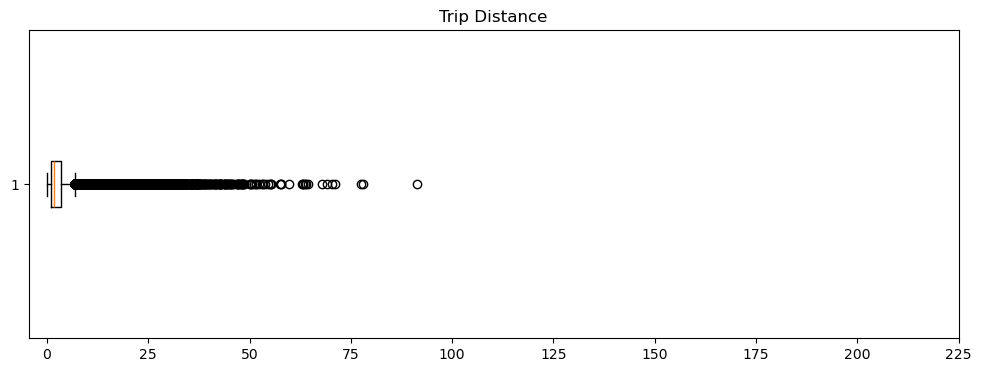

In [316]:
plt.figure(figsize=(12,4))
plt.boxplot(df.trip_distance,vert=False)
plt.title("Trip Distance")
plt.xticks(range(0,250,25))
plt.show()

In [317]:
# Do any columns need standardising?

numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols_mean_std = df[numeric_cols].agg(['mean','std']).T
print(f"Mean and standard deviation of numeric columns: \n\n{numeric_cols_mean_std}")

Mean and standard deviation of numeric columns: 

                             mean        std
VendorID                 1.737422   0.440036
passenger_count          1.384897   0.878261
trip_distance            3.482571   4.521135
RatecodeID               1.060548   0.325282
PULocationID           165.253925  63.553057
DOLocationID           164.266878  69.678291
payment_type             1.199726   0.457066
fare_amount             19.594051  17.825275
extra                    1.652431   1.841919
mta_tax                  0.496880   0.040081
tip_amount               3.580757   4.020559
tolls_amount             0.592594   2.168849
improvement_surcharge    0.999638   0.016374
total_amount            28.748075  22.495955
congestion_surcharge     2.324244   0.639141
airport_fee              0.142654   0.464536
Pickup_day              15.486221   8.705086
Pickup_hour             14.313133   5.779362


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [318]:
df_categorical_cols =[ 'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
                        'Pickup_Date', 'Pickup_Day', 'Pickup_Hour']
df_Numerical_cols =  [ 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                       'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

print(f" Categorical Columns : {df_categorical_cols}")
print(f" Numerical Columns : {df_Numerical_cols}")

 Categorical Columns : ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'Pickup_Date', 'Pickup_Day', 'Pickup_Hour']
 Numerical Columns : ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [ ]:
df.columns

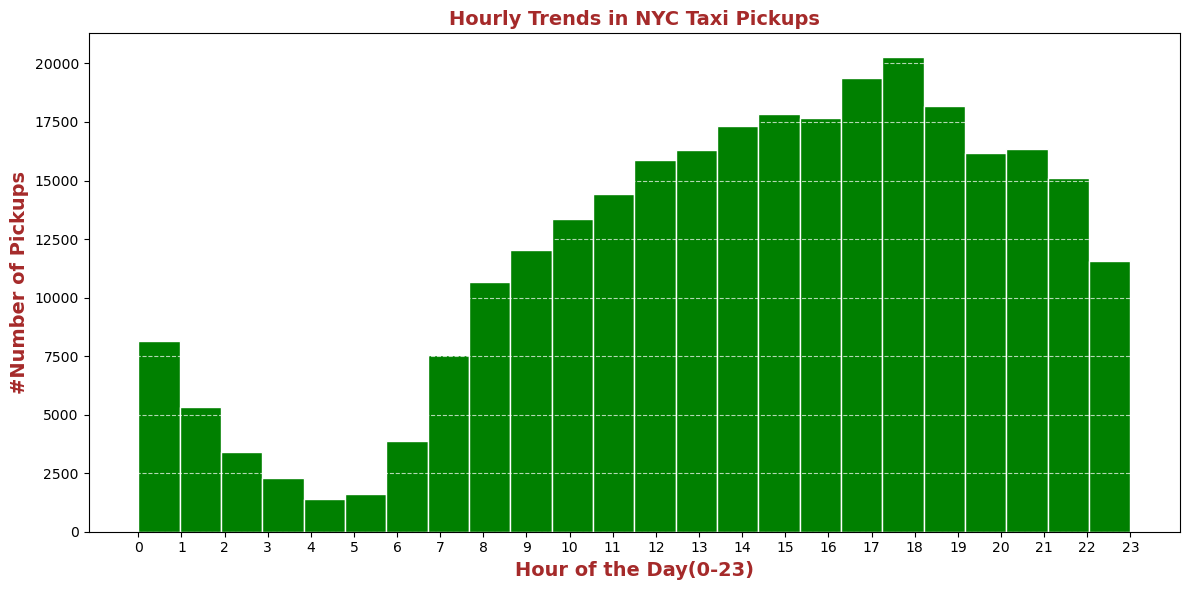

In [319]:
# Find and show the hourly trends in taxi pickups
plt.figure(figsize=(12,6))
plt.hist(df.Pickup_hour,color='green',bins=24,edgecolor='white')
plt.title('Hourly Trends in NYC Taxi Pickups',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Hour of the Day(0-23)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('#Number of Pickups',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xticks(np.arange(0,24,1),fontsize=10) #set xticks for 0-23 Hours 
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white') #set up gridlines 
plt.tight_layout()
plt.show()


**Observation by** <font color = green>Suyash Nagar</font> <br>
- With distribution we can observe that number of pickups is most between 5 tp 7 PM 

In [320]:
# Find and show the daily trends in taxi pickups (days of the week)
df.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour'],
      dtype='object')

In [321]:

# Add Year, Month and Day of week 
df['Pickup_Year'] = df.tpep_pickup_datetime.dt.year #year
df['Pickup_Month'] = df.tpep_pickup_datetime.dt.month_name() #month
df['Pickup_DayName'] = df.tpep_pickup_datetime.dt.day_name() #Day Name


In [322]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour', 'Pickup_Year', 'Pickup_Month',
       'Pickup_DayName'],
      dtype='object')

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286022 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               286022 non-null  int64         
 1   tpep_pickup_datetime   286022 non-null  datetime64[us]
 2   tpep_dropoff_datetime  286022 non-null  datetime64[us]
 3   passenger_count        286022 non-null  float64       
 4   trip_distance          286022 non-null  float64       
 5   RatecodeID             286022 non-null  float64       
 6   store_and_fwd_flag     286022 non-null  object        
 7   PULocationID           286022 non-null  int64         
 8   DOLocationID           286022 non-null  int64         
 9   payment_type           286022 non-null  int64         
 10  fare_amount            286022 non-null  float64       
 11  extra                  286022 non-null  float64       
 12  mta_tax                286022 non-null  float64  

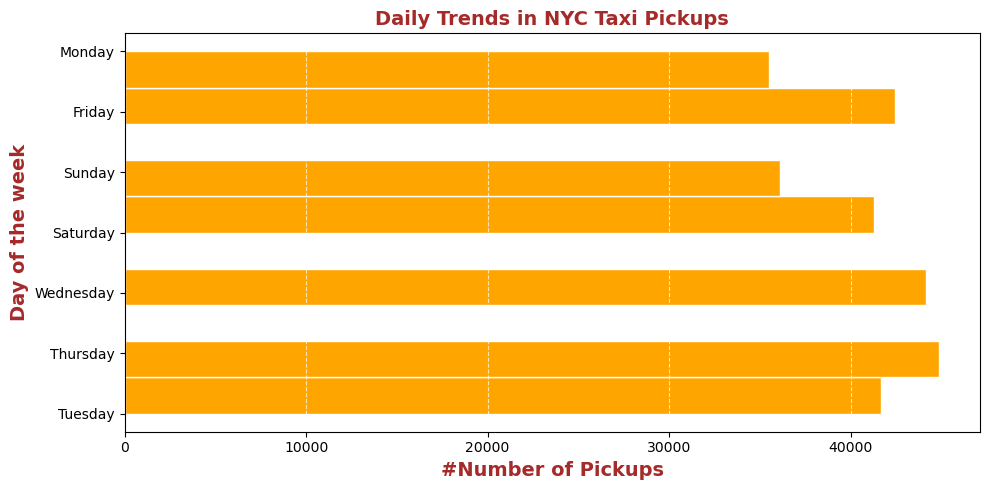

In [324]:
plt.figure(figsize=(10,5))
# Define the order for days of the week Sunday to Saturday
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df['Pickup_DayName'] = pd.Categorical(df['Pickup_DayName'],categories=day_order,ordered=True)
df.sort_values(by='Pickup_DayName')
plt.title('Daily Trends in NYC Taxi Pickups',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.hist(df.Pickup_DayName,color='orange',edgecolor='white',orientation='horizontal')
plt.xlabel('#Number of Pickups',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Day of the week',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.grid(axis='x', linestyle='--', alpha=0.7, color='white') #set up gridlines 
plt.tight_layout()
plt.show()


**Observation by** <font color = green>Suyash Nagar</font> <br>
- From graph we can observe, less pickup on Sundays as its days off and less people commute or go out
- Saturday has good number as people tend to go out on Saturdays and Friday to enjoy nightlife 
- Most Pickups occurs on Wednesday and Thursday  


In [325]:
df.head(2)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
1         2  2023-11-02 12:12:16   2023-11-02 12:20:04              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           6.30         1.0                  N           140            87   
1           1.38         1.0                  N           239            43   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5         7.0           0.0   
1             2          9.3    0.0      0.5         0.0           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0          41.3                   2.5          0.0   
1                    1.0          13.3                   2.5          0.0   

  Pickup_date  Pickup_day  Pickup_hour  Pickup_Year Pickup_Month  \
0  2023-02-14          14            8         2023     February   
1  2023-11-02           2           12         2023     November   

  Pickup_DayName  
0        Tuesday  
1       Thursday

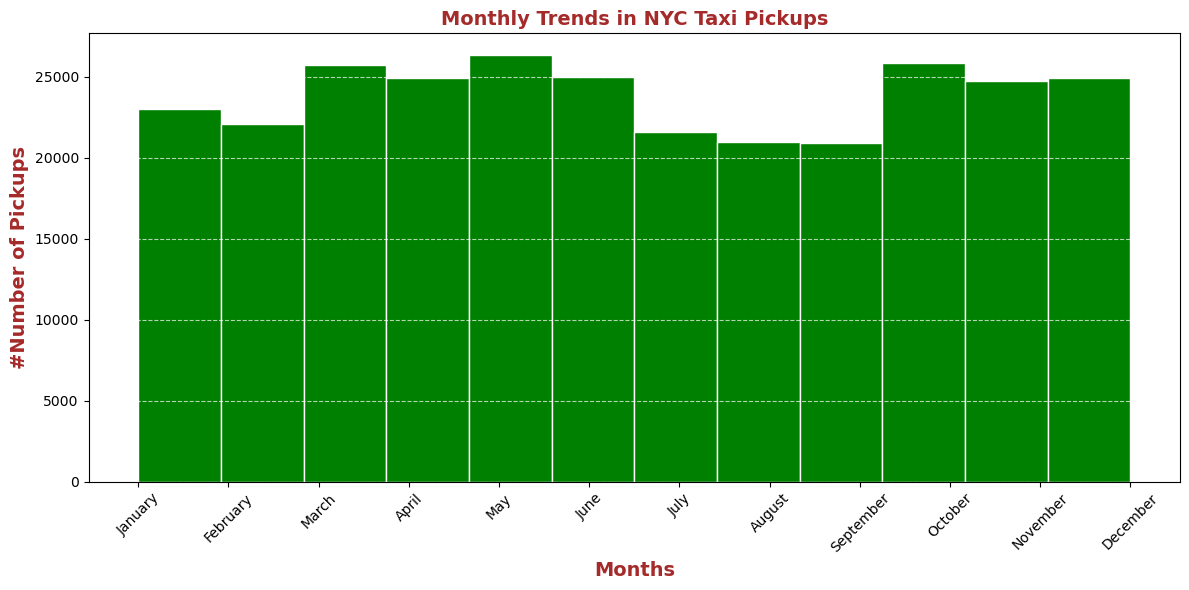

In [326]:
# Show the monthly trends in pickups
# Define Month order
Month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert the Month column to a categorical type with the custom order
df['Pickup_Month'] = pd.Categorical(df['Pickup_Month'], categories=Month_order, ordered=True)

# Sort the DataFrame by the Pickup_Month column
df_sorted = df.sort_values(by='Pickup_Month')

# Plot the monthly trends in pickups
plt.figure(figsize=(12, 6))
plt.title('Monthly Trends in NYC Taxi Pickups', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.hist(df_sorted['Pickup_Month'], color='green', bins=12, edgecolor='white')
plt.xlabel('Months', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('#Number of Pickups', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xticks(rotation=45, fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white') 
plt.tight_layout()
plt.show()

**Observation by** <font color = green>Suyash Nagar</font> <br>
- October , November and December usually have high pickups due to holidays Halloween, Thanksgiving followed Christmas, people tend to shop , go out and travel 
- April and May sees spike as temperature get warmer and people go out on camping and other tripes 


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [328]:
# Analyse the above parameters
financial_parameters = ['fare_amount','tip_amount','total_amount','trip_distance']
for col in financial_parameters:
    zero_values = (df[col] == 0).sum()
    negative_values = (df[col] < 0).sum()
    print(f"Number of zero values in column '{col}': {zero_values} negative :{negative_values}")


Number of zero values in column 'fare_amount': 47 negative :0
Number of zero values in column 'tip_amount': 62503 negative :0
Number of zero values in column 'total_amount': 12 negative :0
Number of zero values in column 'trip_distance': 0 negative :0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [330]:
# Create a df with non zero entries for the selected parameters.
print(f"Shape of the dataframe before removing zero/negative values: {df.shape}")
non_zero_df = df[(df.fare_amount > 0) & (df.tip_amount > 0) & (df.total_amount > 0) & (df.trip_distance > 0)]
print(f"Shape of the dataframe after removing zero/negative values: {non_zero_df.shape}, removed records: {df.shape[0] - non_zero_df.shape[0] }")


Shape of the dataframe before removing zero/negative values: (286022, 25)
Shape of the dataframe after removing zero/negative values: (223518, 25), removed records: 62504


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [331]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour', 'Pickup_Year', 'Pickup_Month',
       'Pickup_DayName'],
      dtype='object')

In [332]:
non_zero_df[['Pickup_Month','total_amount']]

Pickup_Month  total_amount
0          February         41.30
2           October         96.65
3          December        106.97
5              June         26.83
6             April         17.40
...             ...           ...
299994        March         52.50
299995     December         29.00
299996     February         34.40
299997      October         18.75
299998       August         30.80

[223518 rows x 2 columns]

NYC Taxi Monthly Revenue - 2023
   Pickup_Month  total_amount
0       January     507491.88
1      February     484215.17
2         March     585547.27
3         April     570707.26
4           May     614431.28
5          June     591170.41
6          July     486246.54
7        August     477714.24
8     September     507854.76
9       October     623470.14
10     November     581250.79
11     December     579918.69


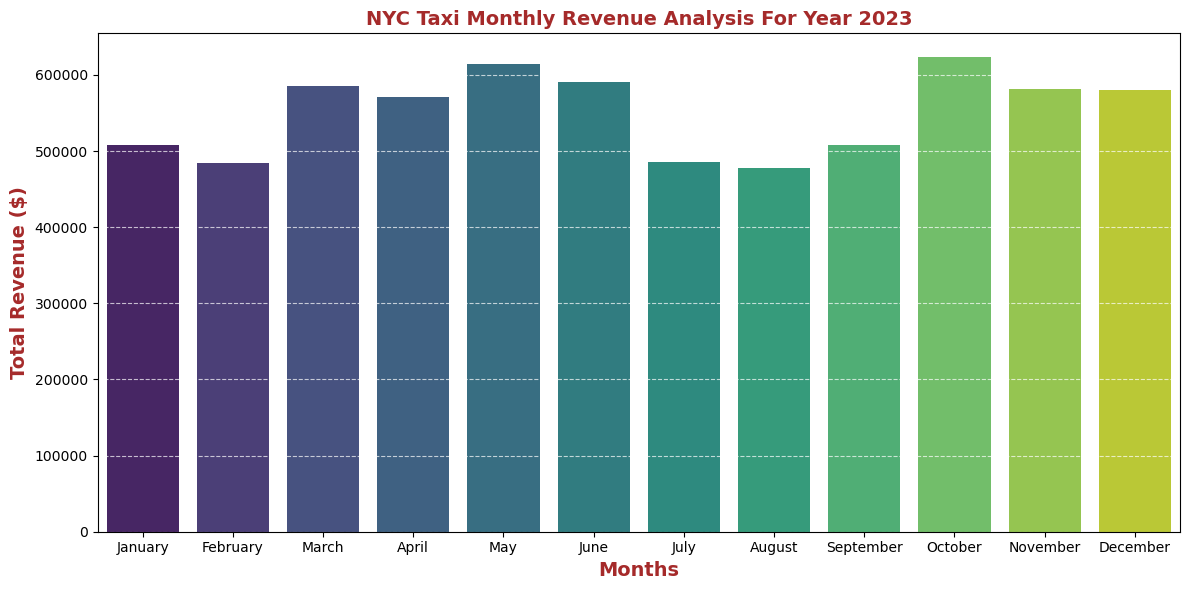

In [333]:
# Group data by month and analyse monthly revenue
montly_revenue2023=non_zero_df.groupby('Pickup_Month', as_index=False)['total_amount'].sum()
print(f"NYC Taxi Monthly Revenue - 2023\n{montly_revenue2023}")
#montly_revenue2023.rename(columns={'Pickup_Month':'Month','total_amount':'Revenue' },inplace=True)
montly_revenue2023.rename(columns={'Pickup_Month': 'Month', 'total_amount': 'Revenue'}, inplace=True)
montly_revenue2023
#plot monthly revenue
plt.figure(figsize=(12, 6))
plt.title('NYC Taxi Monthly Revenue Analysis For Year 2023', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
sns.barplot(x='Month', y='Revenue', data=montly_revenue2023, palette='viridis')
plt.xlabel('Months', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Total Revenue ($)', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # Set up gridlines
plt.tight_layout()

**Observation by** <font color = green>Suyash Nagar</font> <br>
-   Close to ~500000 seem to be average throughout the year 
- March, April, May and then October, November and December seems to be doing well showing  seasonal trends 

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

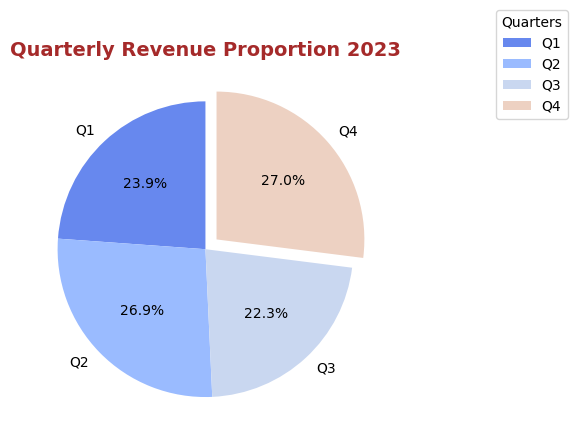

In [334]:
# Calculate proportion of each quarter
Quaterly_revenue=non_zero_df.groupby(non_zero_df.tpep_pickup_datetime.dt.quarter)['total_amount'].sum()/non_zero_df['total_amount'].sum()*100
plt.pie(Quaterly_revenue,labels=['Q1','Q2','Q3','Q4'],autopct='%1.1f%%', startangle=90,colors=sns.color_palette('coolwarm'), explode=(0,0,0,0.1))
plt.title('Quarterly Revenue Proportion 2023',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.legend(title='Quarters', loc='right', bbox_to_anchor=(1.5,1))
plt.tight_layout
plt.show()


**Observation by** <font color = green>Suyash Nagar</font> <br>
-  Q4 is leading followed by Q2 relating to seasonal trends shown in above graph as well

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

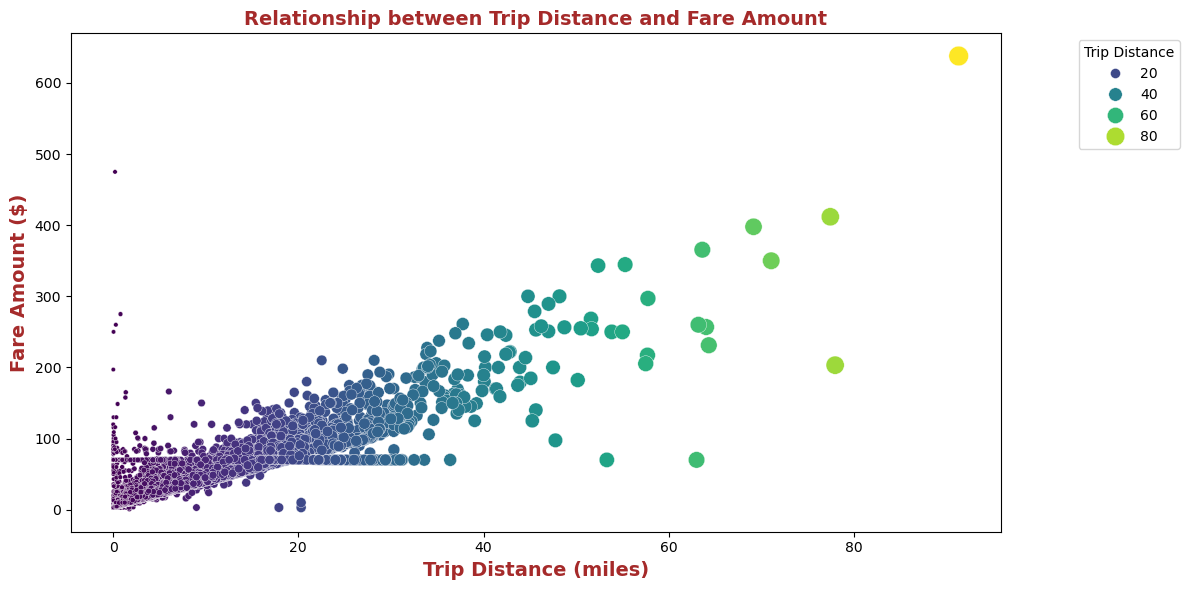

In [335]:
# Show how trip fare is affected by distance
plt.figure(figsize=(12,6))
#plot a scatter chart to show relationship 
plt.title('Relationship between Trip Distance and Fare Amount',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
sns.scatterplot(x='trip_distance',y='fare_amount',data=non_zero_df, palette='viridis',size='trip_distance',sizes=(10,200),hue='trip_distance')
plt.xlabel('Trip Distance (miles)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Fare Amount ($)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.legend(title='Trip Distance', loc='upper right', bbox_to_anchor=(1.2,1))
plt.tight_layout()
plt.show()

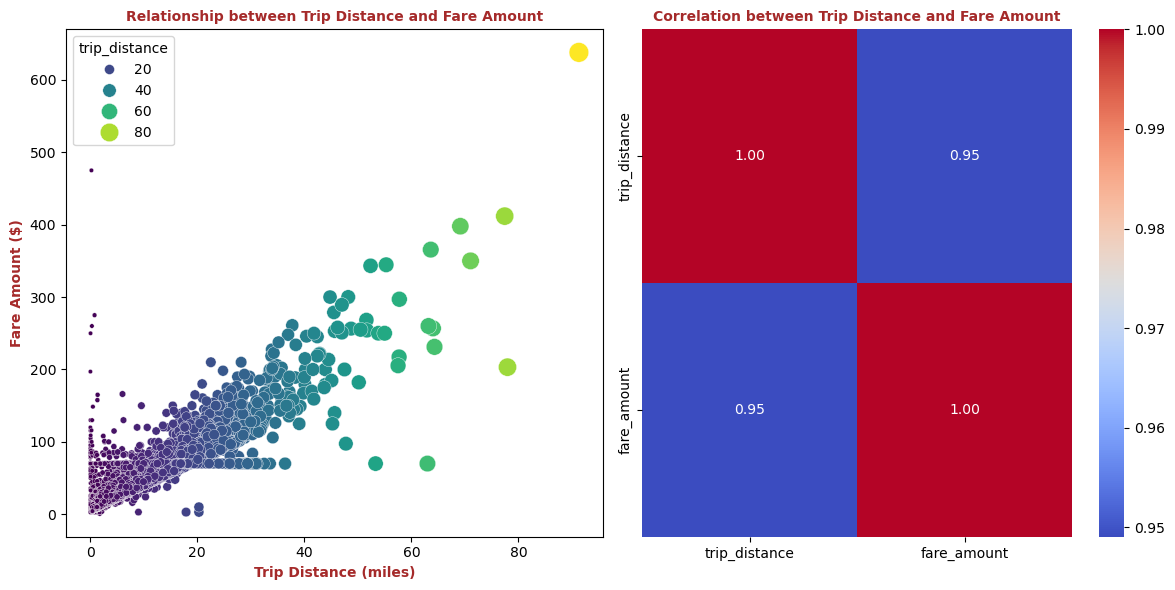

Correlation Matrix :
               trip_distance  fare_amount
trip_distance       1.000000     0.949056
fare_amount         0.949056     1.000000


In [337]:
# Show how trip fare is affected by distance
fig , ax = plt.subplots(1,2, figsize = (12,6))

#plot a scatter chart to show relationship 
sns.scatterplot(ax=ax[0],x='trip_distance',y='fare_amount',data=non_zero_df, palette='viridis',size='trip_distance',sizes=(10,200),hue='trip_distance')
ax[0].set_title('Relationship between Trip Distance and Fare Amount',fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_xlabel('Trip Distance (miles)',fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_ylabel('Fare Amount ($)',fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'brown'})

#plot heatmap to show correlation matrix 
correlation_matrix = non_zero_df[['trip_distance', 'fare_amount']].corr()
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt='.2f', ax=ax[1])
ax[1].set_title('Correlation between Trip Distance and Fare Amount',fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'brown'})

plt.tight_layout()
plt.show()

print(f"Correlation Matrix :\n{correlation_matrix}")


**Observation by** <font color = green>Suyash Nagar</font> <br>
-  There are no trip distance with 0
- There is good relation between Trip Distance and Fare amount which is true as longer distance yield higher fare 
- correlation is strong with 0.95, which also supports this relationship


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [338]:
non_zero_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
2         2  2023-10-11 07:04:36   2023-10-11 08:07:26              2.0   
3         2  2023-12-09 14:07:29   2023-12-09 15:15:16              2.0   
5         2  2023-06-18 23:47:18   2023-06-18 23:56:37              1.0   
6         1  2023-04-09 12:04:28   2023-04-09 12:15:04              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           6.30         1.0                  N           140            87   
2          21.34         1.0                  N           132            14   
3          22.04         2.0                  N           132           142   
5           4.49         1.0                  N           132           219   
6           1.50         1.0                  N           230           246   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5        7.00          0.00   
2             1         88.4    0.0      0.5        5.00          0.00   
3             1         70.0    0.0      0.5       24.28          6.94   
5             1         18.4    1.0      0.5        4.18          0.00   
6             1         11.4    2.5      0.5        2.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.30                   2.5         0.00   
2                    1.0         96.65                   0.0         1.75   
3                    1.0        106.97                   2.5         1.75   
5                    1.0         26.83                   0.0         1.75   
6                    1.0         17.40                   2.5         0.00   

  Pickup_date  Pickup_day  Pickup_hour  Pickup_Year Pickup_Month  \
0  2023-02-14          14            8         2023     February   
2  2023-10-11          11            7         2023      October   
3  2023-12-09           9           14         2023     December   
5  2023-06-18          18           23         2023         June   
6  2023-04-09           9           12         2023        April   

  Pickup_DayName  
0        Tuesday  
2      Wednesday  
3       Saturday  
5         Sunday  
6         Sunday

In [339]:
# Show relationship between fare and trip duration
# calculate trip duration in Hours
non_zero_df['trip_duration'] = np.round( (non_zero_df['tpep_dropoff_datetime'] - non_zero_df['tpep_pickup_datetime']).dt.total_seconds()/3600,2) #convert to minutes

print(f"Correlation Matrix - Fare Amount and Trip Duration\n{non_zero_df[['fare_amount','trip_duration']].corr()}")

# Show relationship between fare and number of passengers
print(f"\nCorrelation Matrix - Fare Amount and Passenger\n{non_zero_df[['fare_amount','passenger_count']].corr()}")

# Show relationship between tip and trip distance
print(f"\nCorrelation Matrix - Tips and Trip Distance\n{non_zero_df[['tip_amount','trip_distance']].corr()}")

Correlation Matrix - Fare Amount and Trip Duration
               fare_amount  trip_duration
fare_amount       1.000000       0.351454
trip_duration     0.351454       1.000000

Correlation Matrix - Fare Amount and Passenger
                 fare_amount  passenger_count
fare_amount           1.0000           0.0403
passenger_count       0.0403           1.0000

Correlation Matrix - Tips and Trip Distance
               tip_amount  trip_distance
tip_amount       1.000000       0.792539
trip_distance    0.792539       1.000000


In [340]:
# Show relationship between fare and number of passengers
print(f"Correlation Matrix - Fare Amount and Passenger\n{non_zero_df[['fare_amount','passenger_count']].corr()}")


Correlation Matrix - Fare Amount and Passenger
                 fare_amount  passenger_count
fare_amount           1.0000           0.0403
passenger_count       0.0403           1.0000


In [ ]:
# Show relationship between tip and trip distance
print(f"Correlation Matrix - Tips and Trip Distance\n{non_zero_df[['tip_amount','trip_distance']].corr()}")


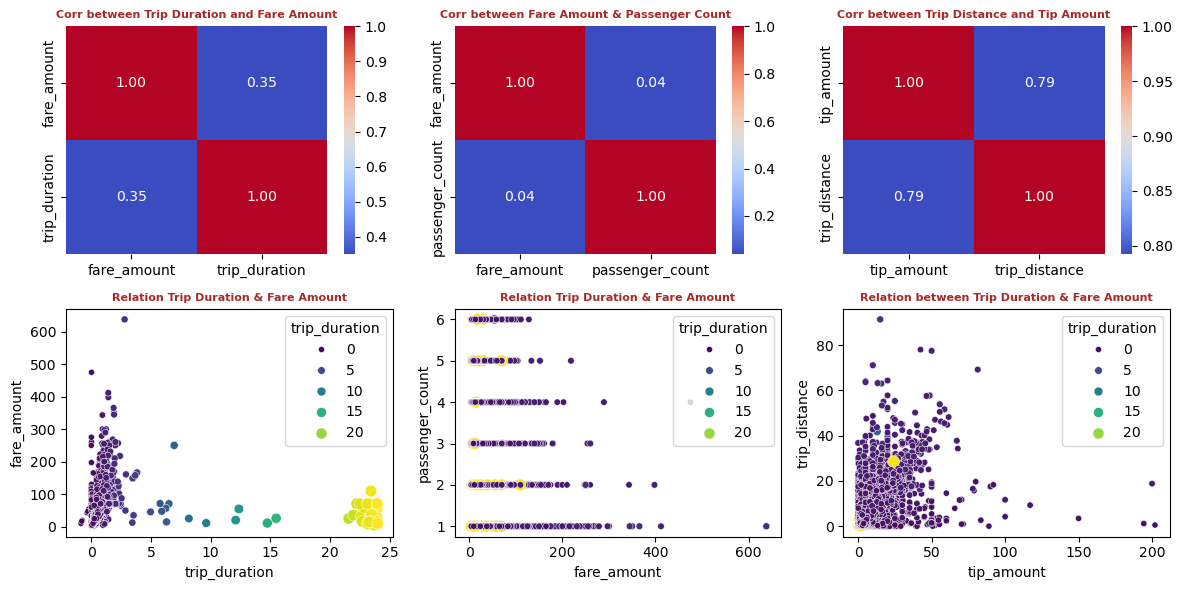

In [341]:
#plot all three correlation 
fig, ax = plt.subplots(2,3,figsize=(12,6))

#Plot correlation matrix
sns.heatmap(non_zero_df[['fare_amount','trip_duration']].corr(),annot=True,cmap='coolwarm',fmt='.2f', ax=ax[0][0])
ax[0][0].set_title('Corr between Trip Duration and Fare Amount',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})
sns.heatmap(non_zero_df[['fare_amount','passenger_count']].corr(),annot=True,cmap='coolwarm',fmt='.2f',ax=ax[0][1])
ax[0][1].set_title('Corr between Fare Amount & Passenger Count',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})
sns.heatmap(non_zero_df[['tip_amount','trip_distance']].corr(),annot=True,cmap='coolwarm',fmt='.2f',ax=ax[0][2])
ax[0][2].set_title('Corr between Trip Distance and Tip Amount',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})

#Plot Scatter graphs
sns.scatterplot(x='trip_duration',y='fare_amount',data=non_zero_df, palette='viridis',size='trip_duration',hue='trip_duration',ax=ax[1][0])
ax[1][0].set_title('Relation Trip Duration & Fare Amount',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})
sns.scatterplot(x='fare_amount',y='passenger_count',data=non_zero_df, palette='viridis',size='trip_duration',hue='trip_duration',ax=ax[1][1])
ax[1][1].set_title('Relation Trip Duration & Fare Amount',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})
sns.scatterplot(x='tip_amount',y='trip_distance',data=non_zero_df, palette='viridis',size='trip_duration',hue='trip_duration',ax=ax[1][2])
ax[1][2].set_title('Relation between Trip Duration & Fare Amount',fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': 'brown'})

plt.tight_layout()
plt.show()


**Observation by** <font color = green>Suyash Nagar</font> <br>
- There is weak correlation of 0.37 between Fare and Trip duration
- There is very weak or almost no between Passenger and fare_amount
- There is 0.79 strong correlation between Trip and Tips longer Trips get moderate to good tips 


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [ ]:
non_zero_df.columns

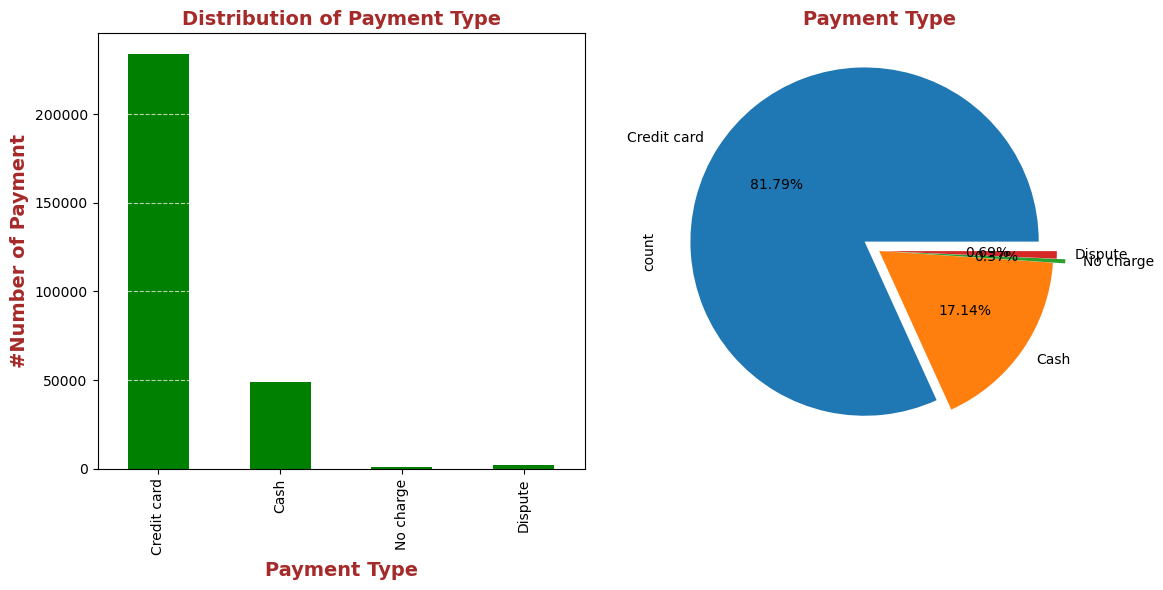

In [342]:
# Analyse the distribution of different payment types (payment_type).
payment_counts= df['payment_type'].value_counts().sort_index()
#Payment Type for Data Dictionery 
payment_labels = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

fig , ax = plt.subplots(1,2, figsize=(12,6))
#Map integer index to labels
payment_counts.index = payment_counts.index.astype(int).map(payment_labels)
payment_counts.plot(kind='bar', color='green',ax=ax[0])
ax[0].set_title('Distribution of Payment Type',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_xlabel('Payment Type',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_ylabel('#Number of Payment',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].grid(axis='y', linestyle='--', alpha=0.7, color='white') #set up gridlines 
#ax[0].set_xticklabels(ax[0].get_xticks(), rotation=0)

#Plot a pie chart to show market share 
payment_counts.plot.pie(y=payment_counts.index, autopct ='%1.2f%%',explode =[0.1,0.0,0.07,0.02],ax=ax[1])
ax[1].set_title('Payment Type',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})

plt.tight_layout()
plt.show()


**Observation by** <font color = green>Suyash Nagar</font> <br>
- Clear demarcation in payment mode preference  
- 81% Payments are made by credit card followed by cash

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [343]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [344]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file(r"C:\Users\Kanak\Desktop\EDANYC\taxi_zones\taxi_zones.shp")# read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

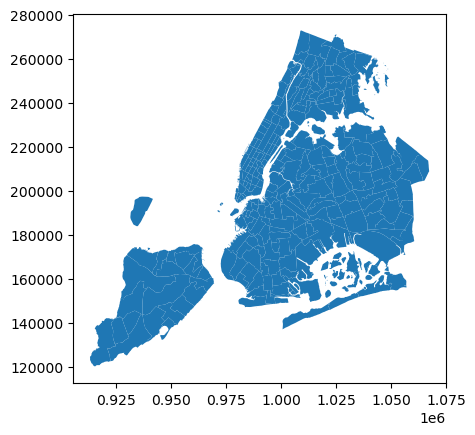

In [345]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [346]:
# Merge zones and trip records using locationID and PULocationID
trips_zone_merge = pd.merge(non_zero_df,zones, left_on='PULocationID', right_on='LocationID', how='left')
#trips_zone_merge.head(5)
trips_zone_merge.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223523 entries, 0 to 223522
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               223523 non-null  int64         
 1   tpep_pickup_datetime   223523 non-null  datetime64[us]
 2   tpep_dropoff_datetime  223523 non-null  datetime64[us]
 3   passenger_count        223523 non-null  float64       
 4   trip_distance          223523 non-null  float64       
 5   RatecodeID             223523 non-null  float64       
 6   store_and_fwd_flag     223523 non-null  object        
 7   PULocationID           223523 non-null  int64         
 8   DOLocationID           223523 non-null  int64         
 9   payment_type           223523 non-null  int64         
 10  fare_amount            223523 non-null  float64       
 11  extra                  223523 non-null  float64       
 12  mta_tax                223523 non-null  floa

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [351]:
# Group data by location and calculate the number of trips
trip_by_location = trips_zone_merge.groupby('LocationID').size().reset_index(name='trips')
trip_by_location.LocationID=trip_by_location.LocationID.astype(int)
trip_by_location.sort_values(by='trips',ascending=False).head()

LocationID  trips
143         237  10816
90          161  10511
142         236  10158
69          132   9972
91          162   8322

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [352]:
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

In [353]:
trip_by_location.head()

LocationID  trips
0           1      5
1           4    218
2           7     38
3           9      1
4          10     44

In [354]:
# Merge trip counts back to the zones GeoDataFrame

Zone_Pickup_Count = zones.merge(trip_by_location, left_on='LocationID', right_on='LocationID', how='left') #merge with trip_counts
#Zone_Pickup_Count.head() #display head
#check for Nulls in trip count that is Location without pickups 
print(f"Count of records with 0 Pick up : {Zone_Pickup_Count.trips.isnull().sum()} out of {Zone_Pickup_Count.shape[0]}")
#Replace nan with 0
Zone_Pickup_Count.trips.fillna(0,inplace=True)
print(f"Count of records after Imputing Pick up : {Zone_Pickup_Count.trips.isnull().sum()} out of {Zone_Pickup_Count.shape[0]}")
Zone_Pickup_Count.head(5)

Count of records with 0 Pick up : 102 out of 263
Count of records after Imputing Pick up : 0 out of 263


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  trips  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...    5.0  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...    0.0  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...    0.0  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  218.0  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...    0.0

**Observation by** <font color = green>Suyash Nagar</font> <br>
- Added grouped trip counts to Zone_Pickup_count dataframe
- Imputed nulls with 0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

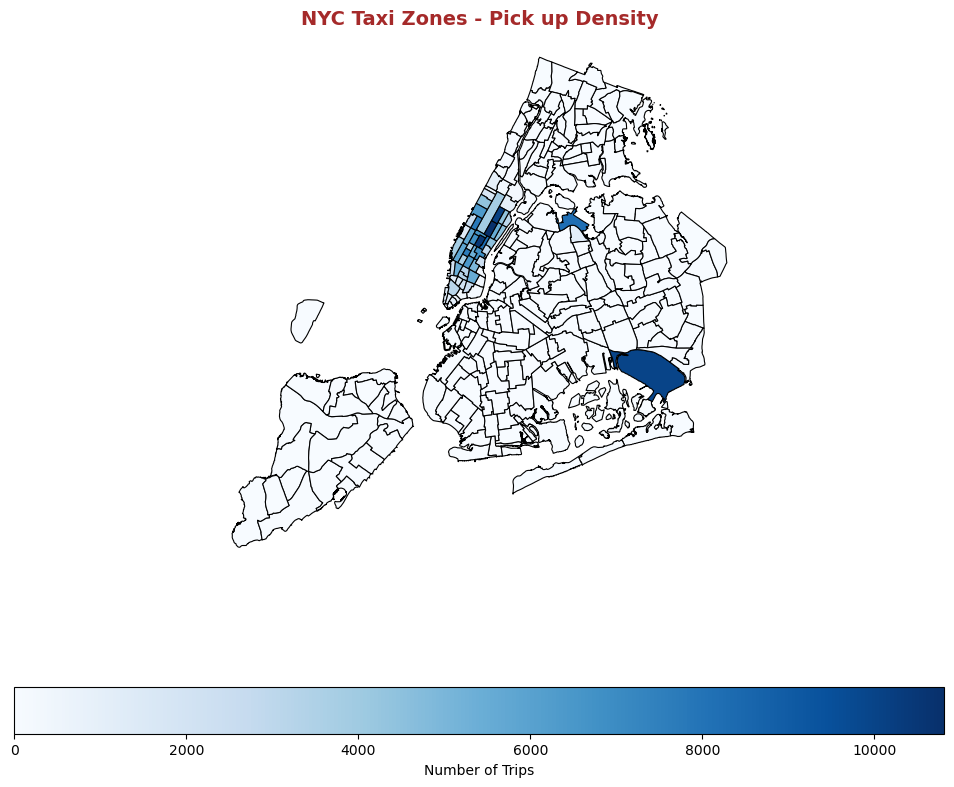

In [355]:
# Define figure and axis
fig, ax = plt.subplots(1,1, figsize=(12,10))

# Plot the map and display it
Zone_Pickup_Count.plot(column='trips', legend_kwds={'label': "Number of Trips",'orientation': "horizontal" },cmap='Blues', linewidth=0.8, ax=ax, edgecolor='Black', legend=True)
plt.title('NYC Taxi Zones - Pick up Density',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.axis('off')
plt.show()



**Observation by** <font color = green>Suyash Nagar</font> <br>
- Shades of blue gets darker with higher pick up density

In [356]:
# can you try displaying the zones DF sorted by the number of trips?

Sorted_zone=Zone_Pickup_Count.sort_values(by='trips', ascending=False)
Sorted_zone[['borough','zone','trips']].head(20)


borough                          zone    trips
236  Manhattan         Upper East Side South  10816.0
160  Manhattan                Midtown Center  10511.0
235  Manhattan         Upper East Side North  10158.0
131     Queens                   JFK Airport   9972.0
161  Manhattan                  Midtown East   8322.0
137     Queens             LaGuardia Airport   8197.0
141  Manhattan           Lincoln Square East   7812.0
185  Manhattan  Penn Station/Madison Sq West   7669.0
169  Manhattan                   Murray Hill   6885.0
229  Manhattan     Times Sq/Theatre District   6824.0
162  Manhattan                 Midtown North   6648.0
233  Manhattan                      Union Sq   6449.0
238  Manhattan         Upper West Side South   6410.0
67   Manhattan                  East Chelsea   5841.0
47   Manhattan                  Clinton East   5830.0
140  Manhattan               Lenox Hill West   5536.0
78   Manhattan                  East Village   5495.0
163  Manhattan                 Midtown South   5363.0
248  Manhattan                  West Village   5337.0
106  Manhattan                      Gramercy   4980.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [357]:
# Find routes which have the slowest speeds at different times of the day
speed_df=non_zero_df[(non_zero_df['trip_duration'] > 0) & (non_zero_df['trip_distance'] > 0)]
speed_df['Speed'] = np.round((non_zero_df['trip_distance'] / non_zero_df['trip_duration']),2) #calculate speed
speed_df.Speed.isnull().sum() #There are no nulls 

#non_zero_df.PickUp_Speed.value_counts()# value counts
speed_df['route'] = speed_df['PULocationID'].astype(str) + ' to ' + speed_df['DOLocationID'].astype(str) #create route column
#speed_df[['route','trip_distance', 'trip_duration','Speed']].sort_values(by='Speed',ascending=True)
speed_df.reset_index(drop=True,inplace=True)
speed_df[['route','trip_distance', 'trip_duration','Speed']].sort_values(by='Speed',ascending=True)

route  trip_distance  trip_duration    Speed
189580  132 to 132           0.01           2.54     0.00
201015  230 to 161           0.33          23.66     0.01
100996  239 to 239           0.53          23.92     0.02
141361  161 to 162           0.40          23.71     0.02
126851    68 to 68           0.01           0.41     0.02
...            ...            ...            ...      ...
191071  265 to 265           6.20           0.01   620.00
56565   140 to 140           9.00           0.01   900.00
75307   141 to 141          17.90           0.01  1790.00
63099   243 to 243          20.30           0.01  2030.00
18734     23 to 23          20.30           0.01  2030.00

[223391 rows x 4 columns]

In [358]:
speed_df.head(2)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
1         2  2023-10-11 07:04:36   2023-10-11 08:07:26              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           6.30         1.0                  N           140            87   
1          21.34         1.0                  N           132            14   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5         7.0           0.0   
1             1         88.4    0.0      0.5         5.0           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.30                   2.5         0.00   
1                    1.0         96.65                   0.0         1.75   

  Pickup_date  Pickup_day  Pickup_hour  Pickup_Year Pickup_Month  \
0  2023-02-14          14            8         2023     February   
1  2023-10-11          11            7         2023      October   

  Pickup_DayName  trip_duration  Speed      route  
0        Tuesday           0.49  12.86  140 to 87  
1      Wednesday           1.05  20.32  132 to 14

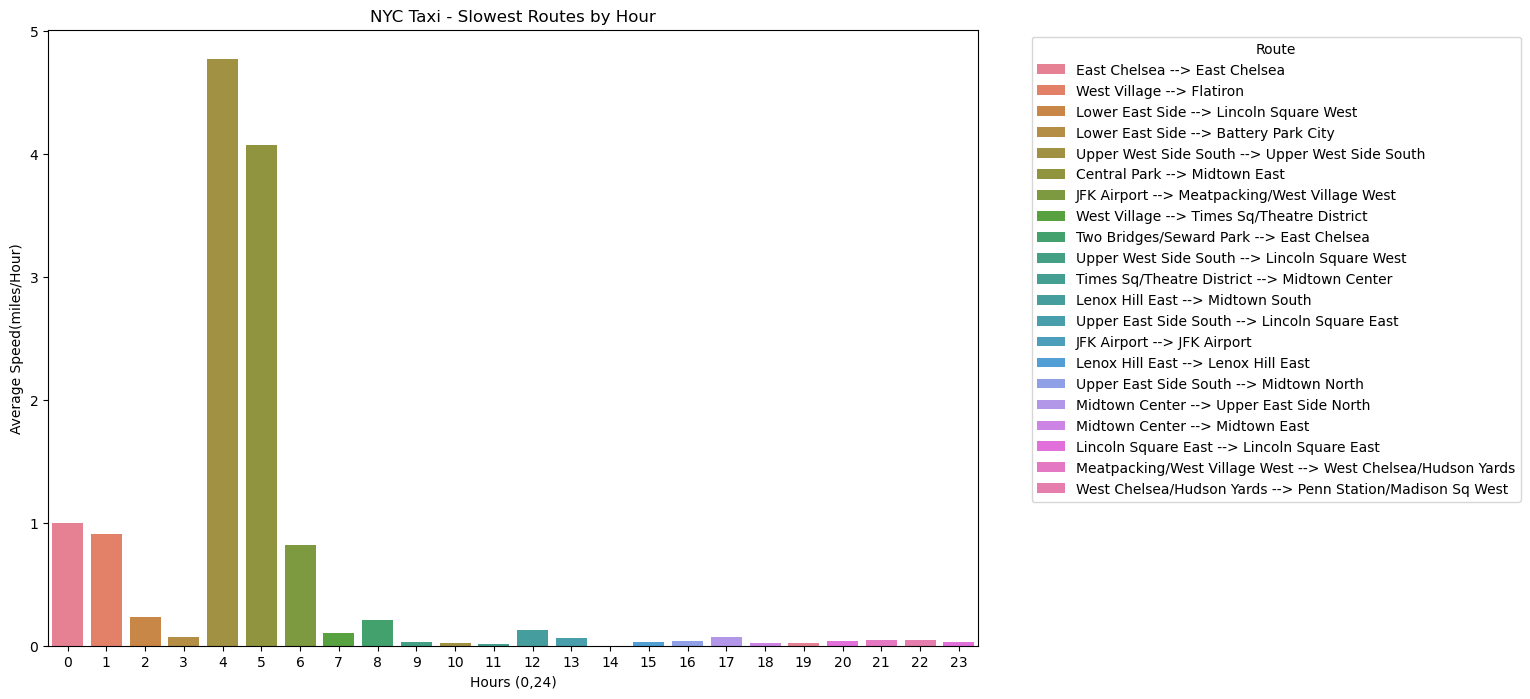

In [359]:
#Calculate by hour and route the average moving traffic
speed_df.groupby(['Pickup_hour','route'])['Speed'].mean().reset_index()
location_lookup = zones.set_index('LocationID')['zone'].to_dict()
# Find slowest route(s) per hour
slowest_by_hour = speed_df.sort_values(['Pickup_hour', 'Speed']).groupby('Pickup_hour').first().reset_index()
# Map Location IDs to zone names
slowest_by_hour['pickup_zone'] = slowest_by_hour['PULocationID'].map(location_lookup)
slowest_by_hour['dropoff_zone'] = slowest_by_hour['DOLocationID'].map(location_lookup)
# Create route name as Pickup Location + Drop off Location
slowest_by_hour['route_by_name'] = slowest_by_hour['pickup_zone'] + ' --> ' + slowest_by_hour['dropoff_zone']
slowest_by_hour[['Pickup_hour','route_by_name','Speed' ]].head(2) #Hour, route and speed

# Plot slow moving/ high- traffic 
plt.figure(figsize=(12,8))
sns.barplot(data=slowest_by_hour,x='Pickup_hour',y='Speed', hue='route_by_name',dodge=False)
plt.title("NYC Taxi - Slowest Routes by Hour")
plt.xlabel("Hours (0,24)")
plt.ylabel("Average Speed(miles/Hour)")
plt.legend(title="Route", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


How does identifying high-traffic, high-demand routes help us?

**Observation by** <font color = green>Suyash Nagar</font> <br>
- Congestion could be reduced or diverted to alternate route
- High demand area can have targeted pricing, such surge charge
- By reducing wait time in high demand areas, customer can get quicker service 
- Taxi company can deploy more vehicles to meet demand efficiently 



**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [360]:
non_zero_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Pickup_date',
       'Pickup_day', 'Pickup_hour', 'Pickup_Year', 'Pickup_Month',
       'Pickup_DayName', 'trip_duration'],
      dtype='object')

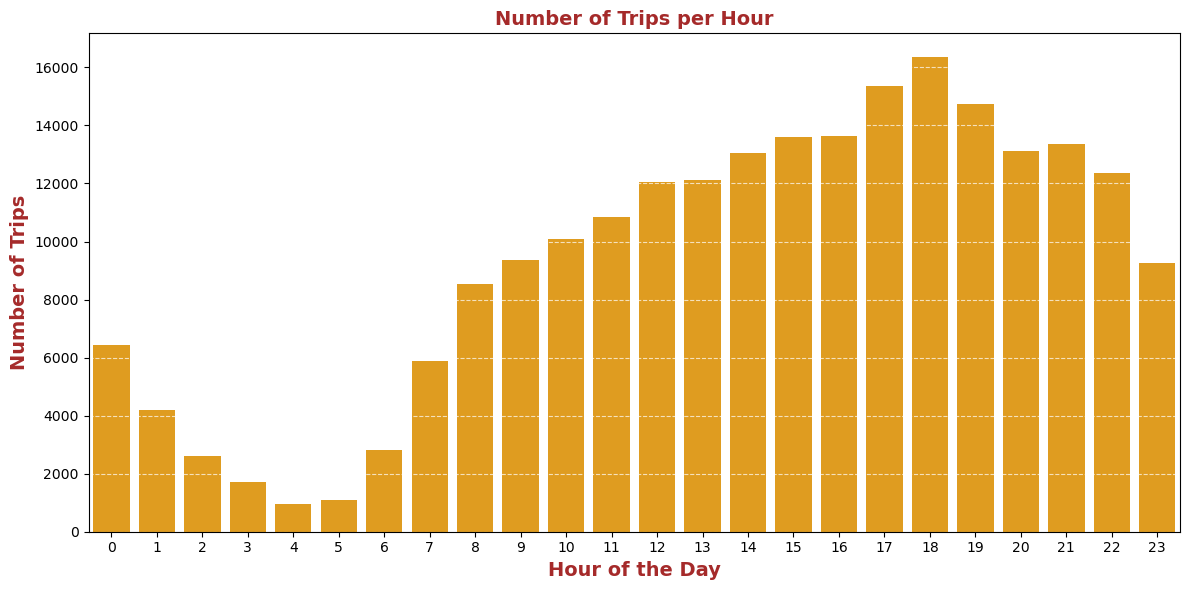

In [361]:
# Visualise the number of trips per hour and find the busiest hour
plt.figure(figsize=(12,6))
Hourly_trips = non_zero_df.Pickup_hour.value_counts()
sns.barplot(x=Hourly_trips.index,y=Hourly_trips.values,color='orange')
plt.title('Number of Trips per Hour',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Hour of the Day',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Number of Trips',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')
plt.tight_layout()
plt.show()



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

Slowest Business Hours
   Pickup_hour  Number_of_Trips
0           18           163550
1           17           153580
2           19           147220
3           16           136480
4           15           136030


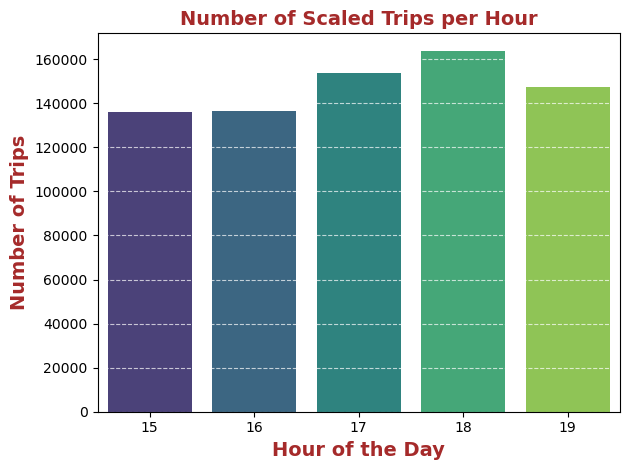

In [362]:
# Scale up the number of trips
# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.10
scaled_tripsby_hour = (Hourly_trips / sample_fraction).round().astype(int)
#print(f"With 10% Sampling, Estimated Trips by hour{scaled_tripsby_hour}")
slowest_top5 = scaled_tripsby_hour.nlargest(5).reset_index(name='Number_of_Trips')
print(f"Slowest Business Hours\n{slowest_top5}")

#plot Slowest Business Hours with trips
sns.barplot(x=slowest_top5.Pickup_hour  ,y=slowest_top5.Number_of_Trips,palette='viridis')  #plot the scaled trips
plt.title('Number of Scaled Trips per Hour',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Hour of the Day',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Number of Trips',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')
plt.tight_layout()
plt.show()



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

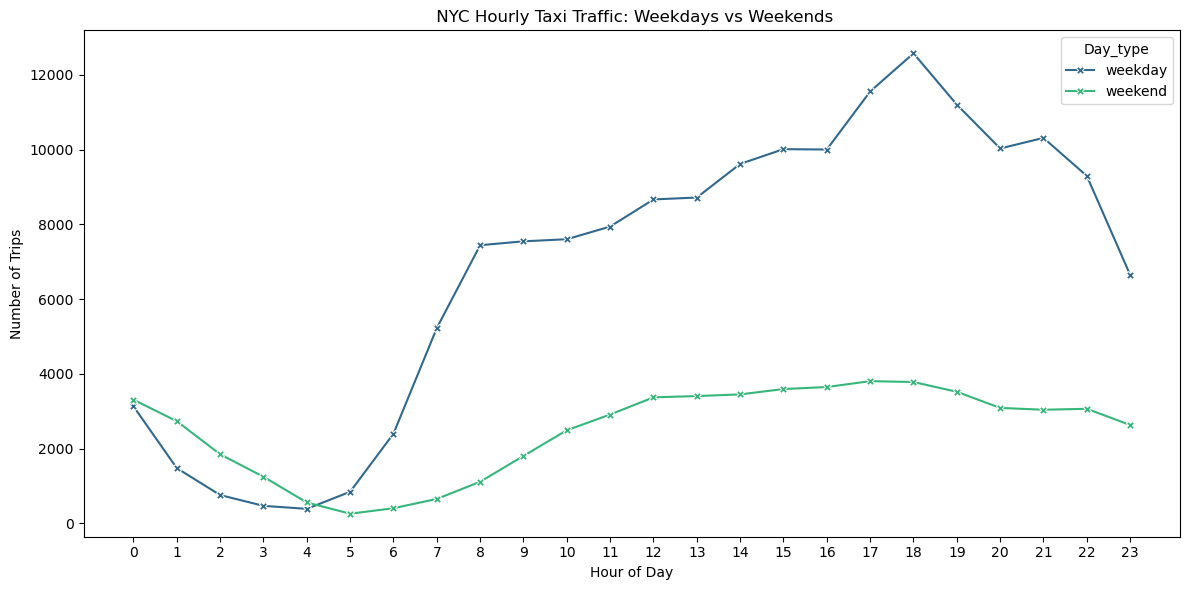

In [363]:
# Compare traffic trends for the week days and weekends

non_zero_df['Day_type'] = non_zero_df['Pickup_DayName'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday') #create weekend column
non_zero_df['Day_type'].value_counts() #count of weekend and weekdays
hourly_tripsby_daytype = non_zero_df.groupby(['Pickup_hour','Day_type']).size().reset_index(name='Trips_Count')
plt.figure(figsize=(12,6))
sns.lineplot(x='Pickup_hour',y='Trips_Count',data=hourly_tripsby_daytype,hue='Day_type',palette='viridis',marker='X') #plot the count of weekend and weekdays
plt.title(" NYC Hourly Taxi Traffic: Weekdays vs Weekends")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
#plt.grid(True)
plt.tight_layout()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

 Top 10 Pickup Zones:
pickup_zone
Upper East Side South           10816
Midtown Center                  10511
Upper East Side North           10158
JFK Airport                      9981
Midtown East                     8322
LaGuardia Airport                8203
Lincoln Square East              7812
Penn Station/Madison Sq West     7670
Murray Hill                      6885
Times Sq/Theatre District        6824
Name: count, dtype: int64
 Top 10 Dropoff Zones:
dropoff_zone
Upper East Side North        10681
Upper East Side South        10051
Midtown Center                8709
Murray Hill                   6953
Upper West Side South         6735
Lincoln Square East           6640
Midtown East                  6493
Times Sq/Theatre District     6187
Lenox Hill West               6152
Midtown North                 5680
Name: count, dtype: int64


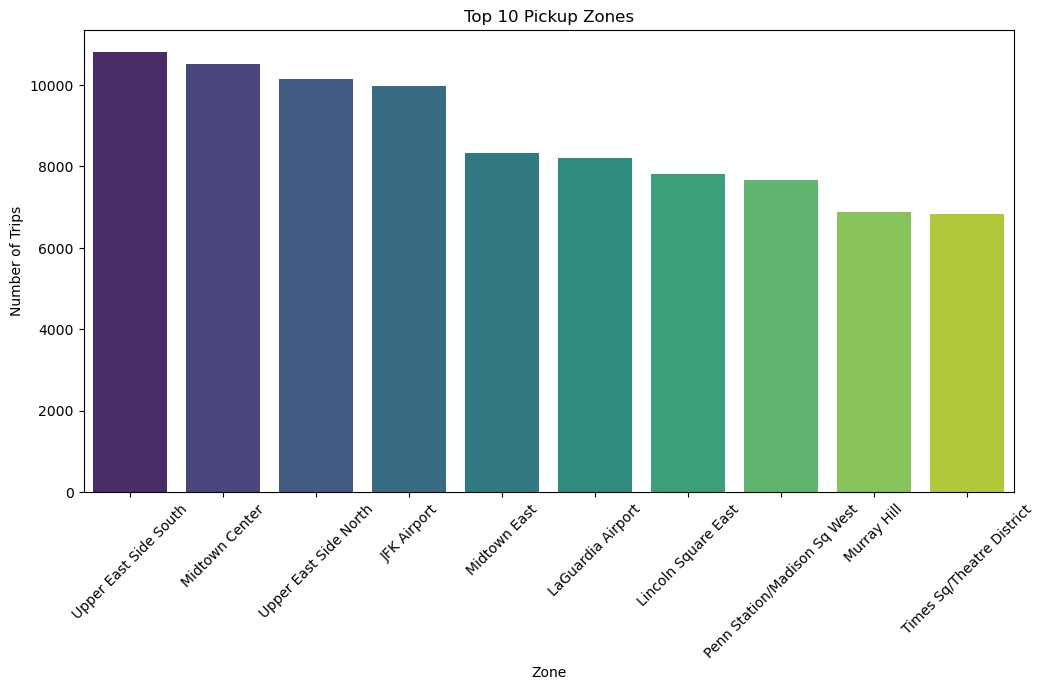

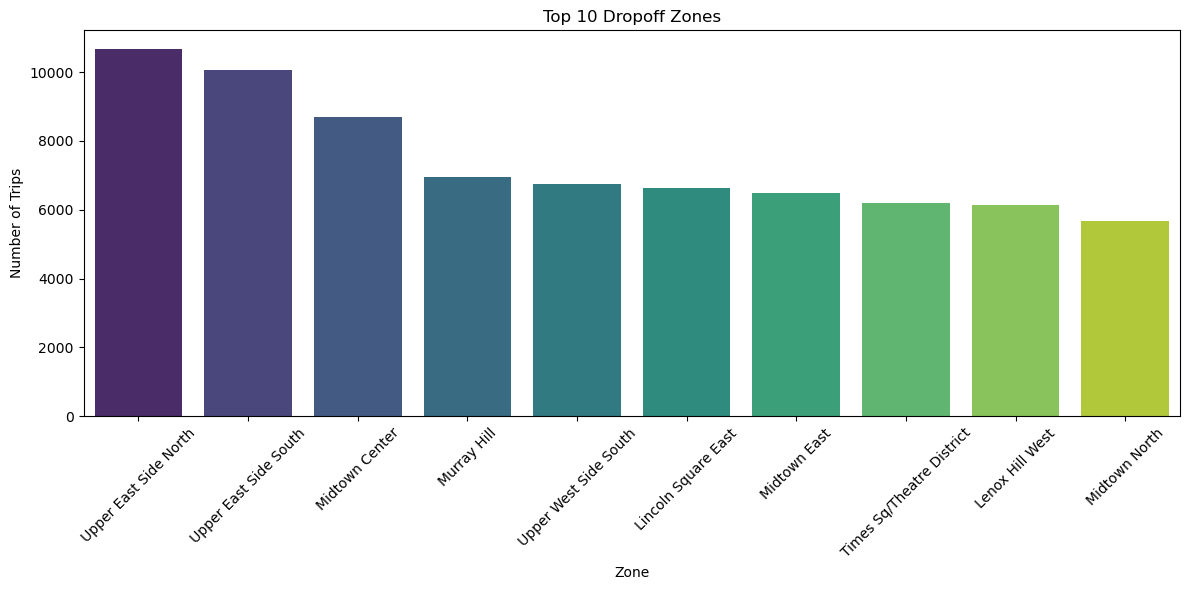

In [364]:
# Find top 10 pickup and dropoff zones
# Find top 10 pickup and dropoff zones
# Rename for clarity
zones_pickup = zones.rename(columns={'LocationID': 'PULocationID', 'zone': 'pickup_zone'})
zones_dropoff = zones.rename(columns={'LocationID': 'DOLocationID', 'zone': 'dropoff_zone'})

# Merge pickup zone
df_zones = non_zero_df.merge(zones_pickup[['PULocationID', 'pickup_zone']], on='PULocationID', how='left')

# Merge dropoff zone
df_zones = df_zones.merge(zones_dropoff[['DOLocationID', 'dropoff_zone']], on='DOLocationID', how='left')

top_pickup_zones = df_zones['pickup_zone'].value_counts().head(10)
print(" Top 10 Pickup Zones:")
print(top_pickup_zones)
top_dropoff_zones = df_zones['dropoff_zone'].value_counts().head(10)
print(" Top 10 Dropoff Zones:")
print(top_dropoff_zones)

#plot pickup zone
plt.figure (figsize=(12, 6))
sns.barplot(x=top_pickup_zones.index, y=top_pickup_zones.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Top 10 Pickup Zones")
plt.xlabel("Zone")
plt.ylabel("Number of Trips")
#plot dropoff zones
plt.figure(figsize=(12, 6))
sns.barplot(x=top_dropoff_zones.index, y=top_dropoff_zones.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Top 10 Dropoff Zones")
plt.xlabel("Zone")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


 Top 10 Pickup Zones:
pickup_zone
Upper East Side South           10816
Midtown Center                  10511
Upper East Side North           10158
JFK Airport                      9981
Midtown East                     8322
LaGuardia Airport                8203
Lincoln Square East              7812
Penn Station/Madison Sq West     7670
Murray Hill                      6885
Times Sq/Theatre District        6824
Name: count, dtype: int64
 Top 10 Dropoff Zones:
dropoff_zone
Upper East Side North        10681
Upper East Side South        10051
Midtown Center                8709
Murray Hill                   6953
Upper West Side South         6735
Lincoln Square East           6640
Midtown East                  6493
Times Sq/Theatre District     6187
Lenox Hill West               6152
Midtown North                 5680
Name: count, dtype: int64


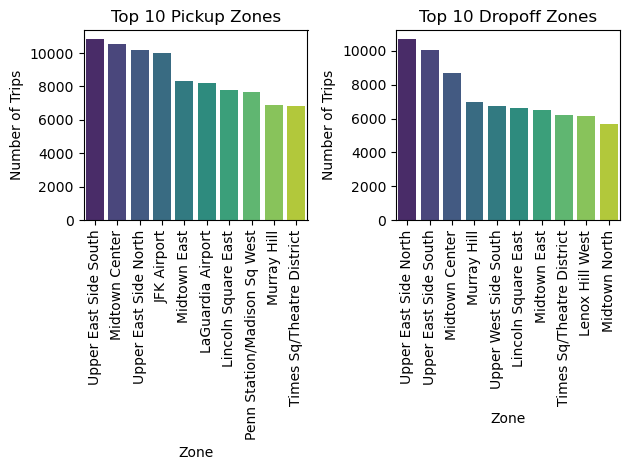

In [365]:
# Find top 10 pickup and dropoff zones

zones_pickup = zones.rename(columns={'LocationID': 'PULocationID', 'zone': 'pickup_zone'})
zones_dropoff = zones.rename(columns={'LocationID': 'DOLocationID', 'zone': 'dropoff_zone'})

# Merge pickup zone
df_zones = non_zero_df.merge(zones_pickup[['PULocationID', 'pickup_zone']], on='PULocationID', how='left')

# Merge dropoff zone
df_zones = df_zones.merge(zones_dropoff[['DOLocationID', 'dropoff_zone']], on='DOLocationID', how='left')

top_pickup_zones = df_zones['pickup_zone'].value_counts().head(10)
print(" Top 10 Pickup Zones:")
print(top_pickup_zones)
top_dropoff_zones = df_zones['dropoff_zone'].value_counts().head(10)
print(" Top 10 Dropoff Zones:")
print(top_dropoff_zones)

fix ,ax = plt.subplots(1,2, figure=(20,12))
#plot pickup zone
sns.barplot(x=top_pickup_zones.index, y=top_pickup_zones.values, palette='viridis',ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels
ax[0].set_title("Top 10 Pickup Zones")
ax[0].set_xlabel("Zone")
ax[0].set_ylabel("Number of Trips")

#plot dropoff zones
sns.barplot(x=top_dropoff_zones.index, y=top_dropoff_zones.values, palette='viridis',ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels
ax[1].set_title("Top 10 Dropoff Zones")
ax[1].set_xlabel("Zone")
ax[1].set_ylabel("Number of Trips")

plt.tight_layout()
plt.show()


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [366]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Count pickups
pickup_counts = df_zones['pickup_zone'].value_counts().rename("pickup_count")

# Count drop-offs
dropoff_counts = df_zones['dropoff_zone'].value_counts().rename("dropoff_count")

# Combine into one DataFrame
zone_ratios = pd.concat([pickup_counts, dropoff_counts], axis=1).fillna(0)
# Avoid division by zero
zone_ratios['pickup_dropoff_ratio'] = zone_ratios['pickup_count'] / zone_ratios['dropoff_count'].replace(0, 1)
# Top 10 zones with highest pickup-to-dropoff ratio
top_10_ratio = zone_ratios.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)

# Bottom 10 zones with lowest pickup-to-dropoff ratio
bottom_10_ratio = zone_ratios.sort_values(by='pickup_dropoff_ratio').head(10)
print(" Top 10 Zones (More Pickups than Drop-offs):")
print(top_10_ratio[['pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])

print(" Bottom 10 Zones (More Drop-offs than Pickups):")
print(bottom_10_ratio[['pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])


 Top 10 Zones (More Pickups than Drop-offs):
                                  pickup_count  dropoff_count  \
East Elmhurst                           1057.0             64   
JFK Airport                             9981.0           2092   
Saint Michaels Cemetery/Woodside           3.0              1   
LaGuardia Airport                       8203.0           2869   
Penn Station/Madison Sq West            7670.0           4732   
Central Park                            3881.0           2736   
Greenwich Village South                 3259.0           2304   
West Village                            5337.0           4032   
Midtown East                            8322.0           6493   
Garment District                        3420.0           2775   

                                  pickup_dropoff_ratio  
East Elmhurst                                16.515625  
JFK Airport                                   4.771033  
Saint Michaels Cemetery/Woodside              3.000000  
LaGuardia A

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [367]:
non_zero_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   
2         2  2023-10-11 07:04:36   2023-10-11 08:07:26              2.0   
3         2  2023-12-09 14:07:29   2023-12-09 15:15:16              2.0   
5         2  2023-06-18 23:47:18   2023-06-18 23:56:37              1.0   
6         1  2023-04-09 12:04:28   2023-04-09 12:15:04              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           6.30         1.0                  N           140            87   
2          21.34         1.0                  N           132            14   
3          22.04         2.0                  N           132           142   
5           4.49         1.0                  N           132           219   
6           1.50         1.0                  N           230           246   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5        7.00          0.00   
2             1         88.4    0.0      0.5        5.00          0.00   
3             1         70.0    0.0      0.5       24.28          6.94   
5             1         18.4    1.0      0.5        4.18          0.00   
6             1         11.4    2.5      0.5        2.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.30                   2.5         0.00   
2                    1.0         96.65                   0.0         1.75   
3                    1.0        106.97                   2.5         1.75   
5                    1.0         26.83                   0.0         1.75   
6                    1.0         17.40                   2.5         0.00   

  Pickup_date  Pickup_day  Pickup_hour  Pickup_Year Pickup_Month  \
0  2023-02-14          14            8         2023     February   
2  2023-10-11          11            7         2023      October   
3  2023-12-09           9           14         2023     December   
5  2023-06-18          18           23         2023         June   
6  2023-04-09           9           12         2023        April   

  Pickup_DayName  trip_duration Day_type  
0        Tuesday           0.49  weekday  
2      Wednesday           1.05  weekday  
3       Saturday           1.13  weekend  
5         Sunday           0.16  weekend  
6         Sunday           0.18  weekend

Top 10 Night Hour Pickup Zones:
pickup_zone
East Village                    1970
West Village                    1690
JFK Airport                     1487
Lower East Side                 1308
Clinton East                    1304
Greenwich Village South         1173
Times Sq/Theatre District        885
Penn Station/Madison Sq West     853
Midtown South                    779
LaGuardia Airport                756
Name: count, dtype: int64

 Top 10 Night Hour Dropoff Zones:
dropoff_zone
East Village                     1014
Murray Hill                       847
Clinton East                      838
Gramercy                          761
Lenox Hill West                   723
East Chelsea                      710
Yorkville West                    684
West Village                      670
Sutton Place/Turtle Bay North     572
Upper East Side North             559
Name: count, dtype: int64


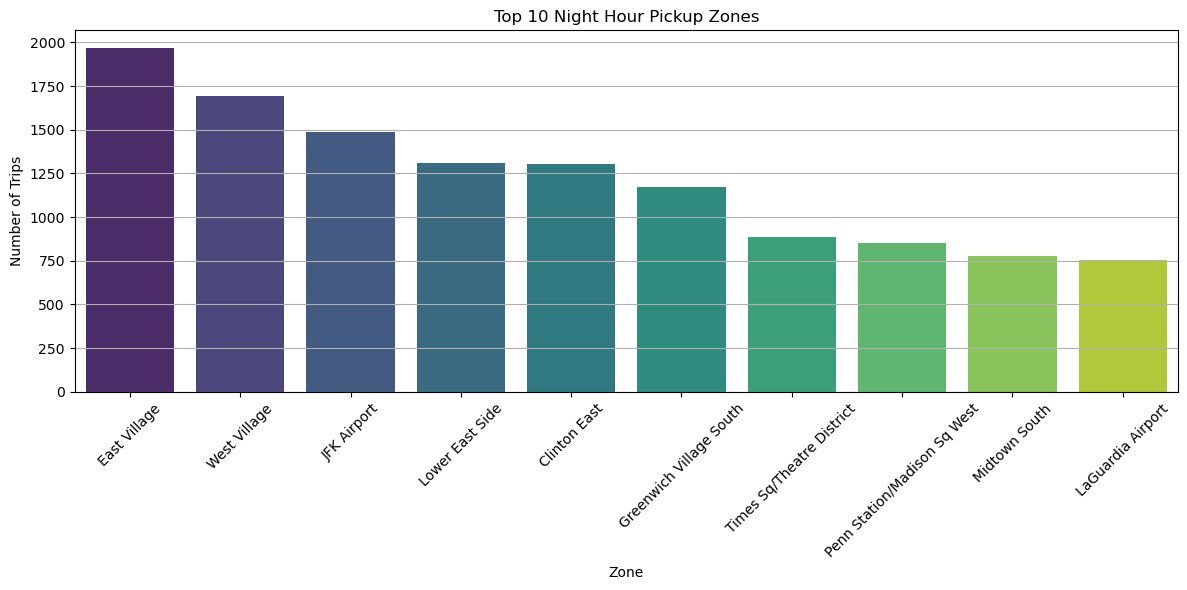

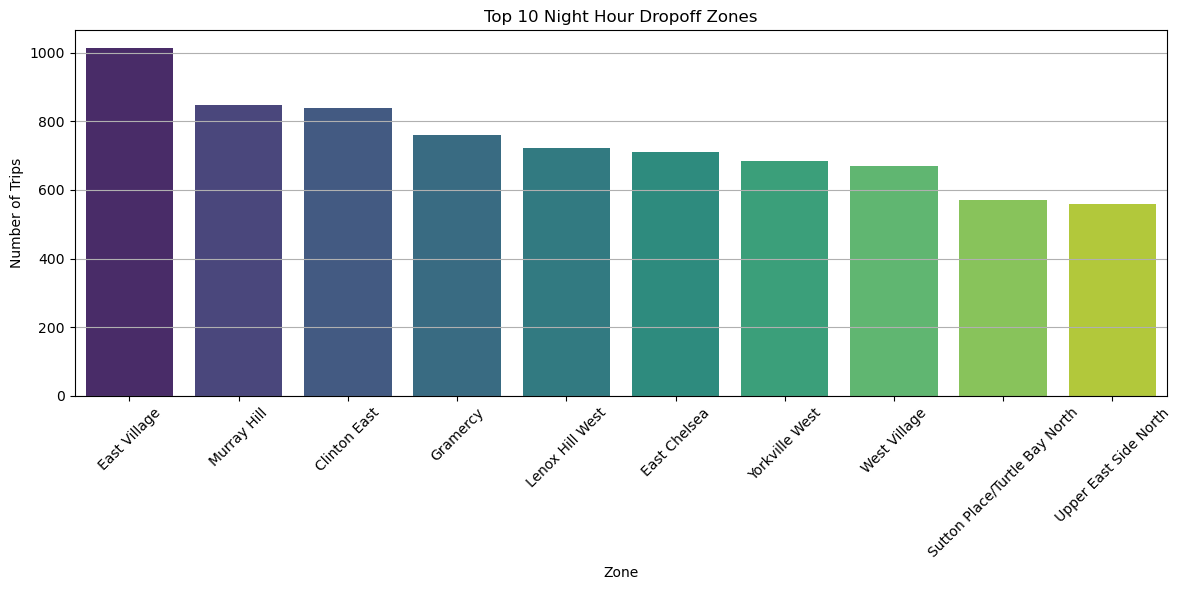

In [368]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filter for night trips (from 11 PM to 5 AM)
night_trips = non_zero_df[(non_zero_df['Pickup_hour'] >= 23) | (non_zero_df['Pickup_hour'] <= 5)]
# Reuse or redefine zone mappings
zones_pickup = zones.rename(columns={'LocationID': 'PULocationID', 'zone': 'pickup_zone'})
zones_dropoff = zones.rename(columns={'LocationID': 'DOLocationID', 'zone': 'dropoff_zone'})

# Merging pickup and dropoff zone names into night_trips
night_trips = night_trips.merge(zones_pickup[['PULocationID', 'pickup_zone']], on='PULocationID', how='left')
night_trips = night_trips.merge(zones_dropoff[['DOLocationID', 'dropoff_zone']], on='DOLocationID', how='left')
# Counting pickups
top_night_pickups = night_trips['pickup_zone'].value_counts().head(10)

# Counting dropoffs
top_night_dropoffs = night_trips['dropoff_zone'].value_counts().head(10)

# Displaying
print("Top 10 Night Hour Pickup Zones:")
print(top_night_pickups)

print("\n Top 10 Night Hour Dropoff Zones:")
print(top_night_dropoffs)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_night_pickups.index, y=top_night_pickups.values, palette='viridis')

plt.title("Top 10 Night Hour Pickup Zones")
plt.xlabel("Zone")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_night_dropoffs.index, y=top_night_dropoffs.values, palette='viridis')

plt.title("Top 10 Night Hour Dropoff Zones")
plt.xlabel("Zone")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
non_zero_df.head(1)

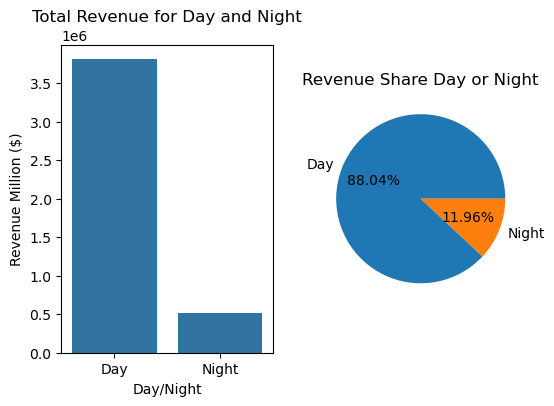

In [369]:
# Filter for night hours (11 PM to 5 AM) else day
non_zero_df['Night_Hour'] = non_zero_df['Pickup_hour'].apply(lambda x: 'Night' if x in [23,0,1,2,3,4,5] else 'Day')
revenue2023=non_zero_df[['fare_amount','Night_Hour']].groupby('Night_Hour').sum().reset_index()

fig, ax = plt.subplots(1,2,figsize=(6,4))

#plot barchart to show revenue 

sns.barplot(data=revenue2023,x='Night_Hour',y='fare_amount',ax=ax[0])
ax[0].set_title("Total Revenue for Day and Night")
ax[0].set_xlabel("Day/Night")
ax[0].set_ylabel("Revenue Million ($)")

#plot pie chart to show revenue %
ax[1].pie(revenue2023.fare_amount,labels=revenue2023.Night_Hour,autopct='%1.2f%%')
ax[1].set_title("Revenue Share Day or Night")

plt.show()
 


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

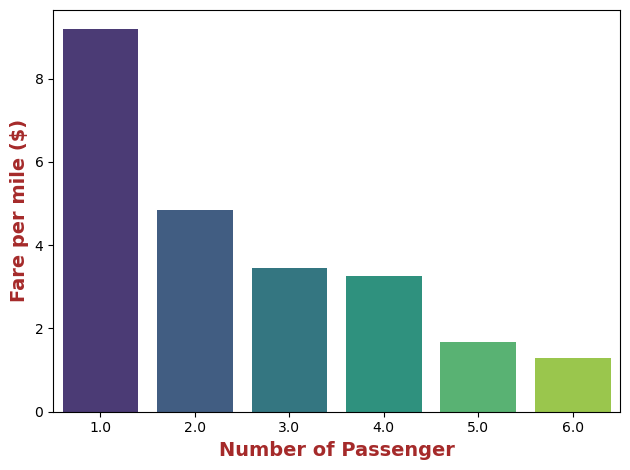

In [370]:
# Analyse the fare per mile per passenger for different passenger counts
non_zero_df.passenger_count.value_counts()
non_zero_df[['passenger_count','trip_distance','fare_amount']].head(2)
non_zero_df['fare_per_mile_per_passenger'] = non_zero_df['fare_amount'] / (non_zero_df['trip_distance'] * non_zero_df['passenger_count']) #calculate fare per mile per passenger

fare_analysis=non_zero_df[['passenger_count','fare_per_mile_per_passenger']].groupby('passenger_count')['fare_per_mile_per_passenger'].mean().round(2).reset_index()
sns.barplot(x='passenger_count', y='fare_per_mile_per_passenger', data=fare_analysis, palette='viridis')
plt.xlabel('Number of Passenger', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Fare per mile ($)', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})

plt.tight_layout()
plt.show()


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

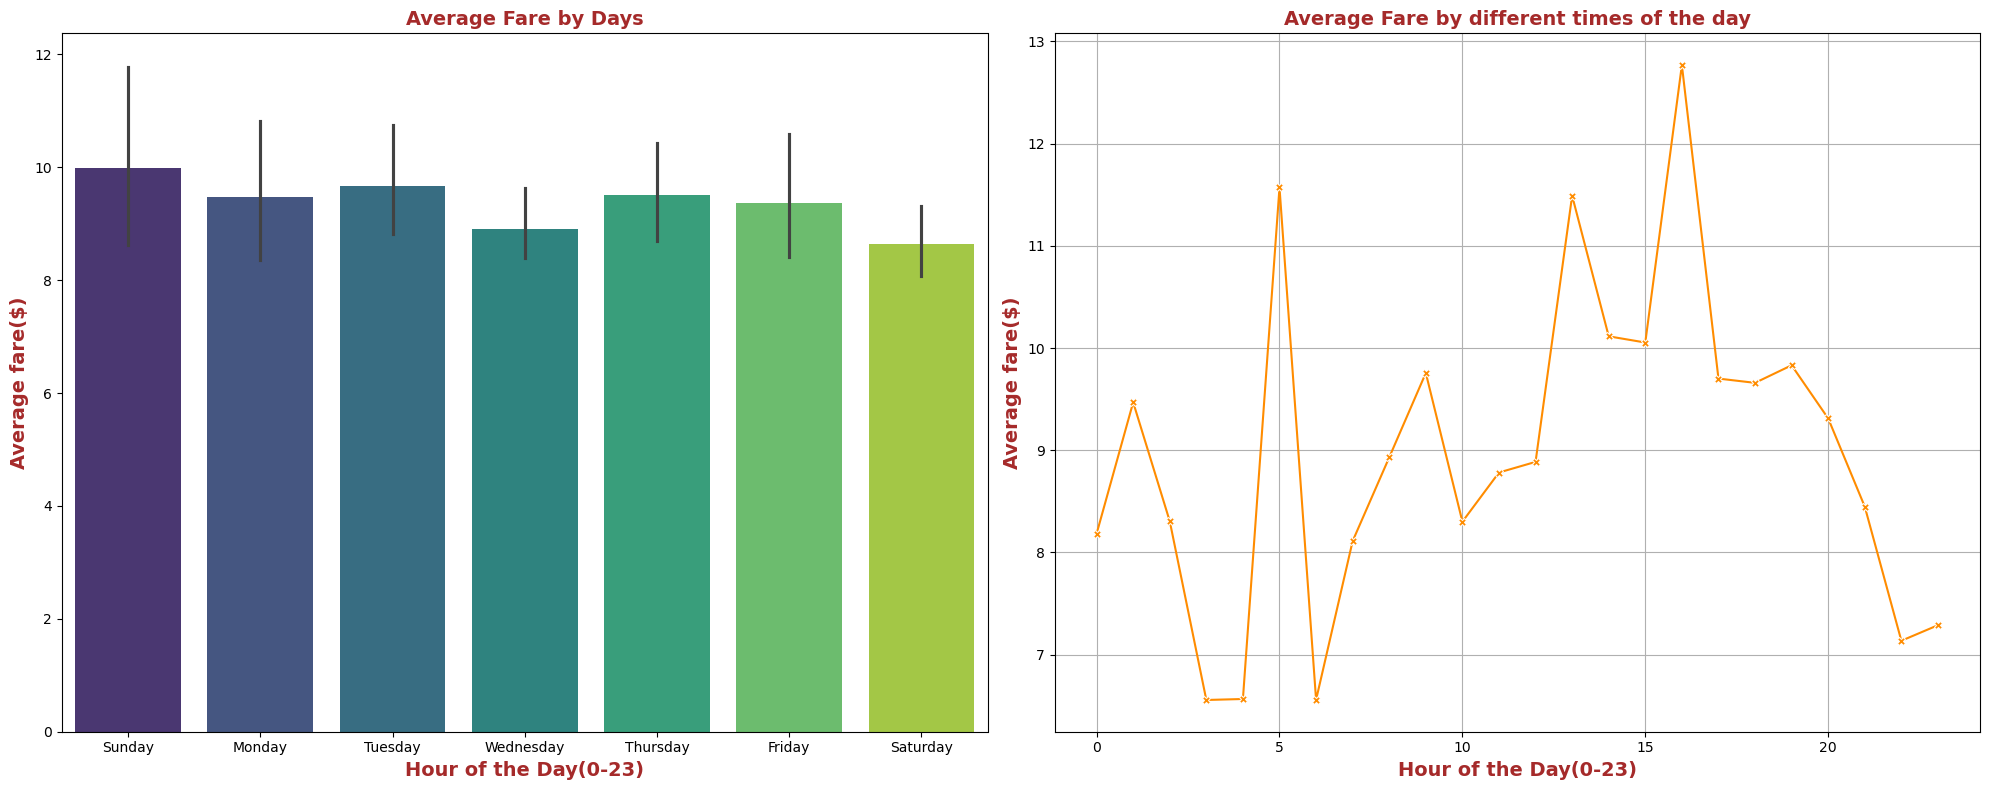

In [371]:
# Compare the average fare per mile for different days and for different times of the day

#Day wise anlaysis
non_zero_df.passenger_count.value_counts()
non_zero_df[['passenger_count','trip_distance','fare_amount']].head(2)
non_zero_df['fare_per_mile'] = non_zero_df['fare_amount'] / (non_zero_df['trip_distance'] ) #calculate fare per mile per passenger
non_zero_df[['Pickup_date','Pickup_day','Pickup_DayName', 'Pickup_hour','fare_amount','fare_per_mile']]

fig,ax = plt.subplots(1,2,figsize=(20,8))
sns.barplot(x='Pickup_DayName',y='fare_per_mile',data=non_zero_df,palette='viridis',ax=ax[0])  #plot the scaled trips
ax[0].set_title('Average Fare by Days',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_xlabel('Hour of the Day(0-23)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_ylabel('Average fare($)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
#Hourly analysis 

hourly_fare = non_zero_df.groupby('Pickup_hour')['fare_per_mile'].mean().reset_index()
sns.lineplot(x=hourly_fare.Pickup_hour,y=hourly_fare.fare_per_mile,ax=ax[1],marker='X', color='darkorange')
ax[1].set_title('Average Fare by different times of the day',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[1].set_xlabel('Hour of the Day(0-23)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[1].set_ylabel('Average fare($)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.grid()
plt.tight_layout()
plt.show()



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

Average Fare per Mile by Vendor:
VendorID
CMT         7.94
VeriFone    9.83
Name: fare_per_mile, dtype: float64


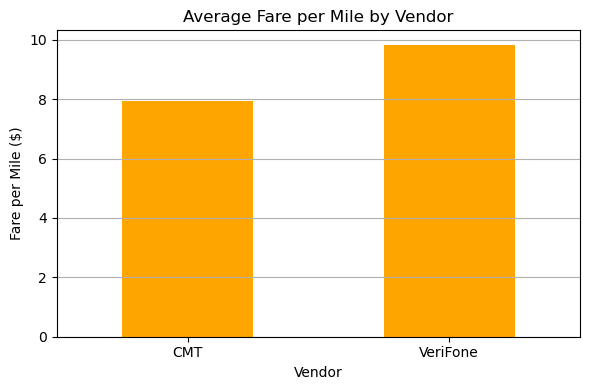

In [372]:
# Compare fare per mile for different vendors
non_zero_df['fare_per_mile'] = non_zero_df['fare_amount'] / non_zero_df['trip_distance']

# Calculate average fare for diffrent VendorID
fare_by_vendor = non_zero_df.groupby('VendorID')['fare_per_mile'].mean().round(2)

# vendor names
vendor_names = {1: 'CMT', 2: 'VeriFone'}
fare_by_vendor.index = fare_by_vendor.index.map(vendor_names)

print("Average Fare per Mile by Vendor:")
print(fare_by_vendor)
fare_by_vendor.plot(kind='bar', color='orange', figsize=(6, 4))

plt.title("Average Fare per Mile by Vendor")
plt.xlabel("Vendor")
plt.ylabel("Fare per Mile ($)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


Tiered Average Fare per Mile by Vendor:
distance_tier  0–2 miles  2–5 miles  >5 miles
VendorID                                     
CMT                 9.55       6.36      4.47
VeriFone           13.25       6.53      4.50


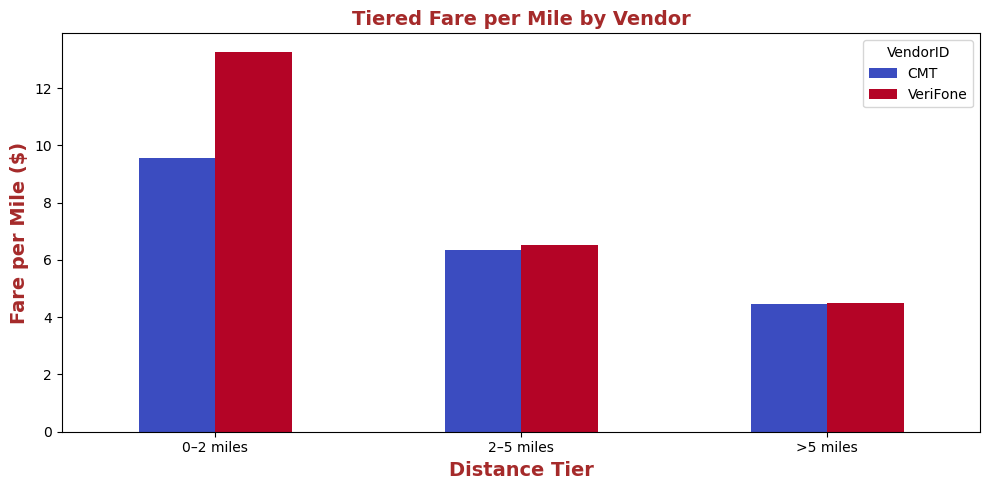

In [373]:
# Defining distance tiers

# Defining distance tiers
# Filtering valid trips
df_tiered = non_zero_df[(non_zero_df['fare_amount'] > 0) & (non_zero_df['trip_distance'] > 0)].copy()

# Creating distance tiers
df_tiered['distance_tier'] = pd.cut(
    df_tiered['trip_distance'],
    bins=[0, 2, 5, float('inf')],
    labels=['0–2 miles', '2–5 miles', '>5 miles']
)
df_tiered['fare_per_mile'] = df_tiered['fare_amount'] / df_tiered['trip_distance']
# Group by vendor and distance tier
tiered_fare = df_tiered.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().round(2).unstack()

# Rename VendorID
vendor_map = {1: 'CMT', 2: 'VeriFone'}
tiered_fare.index = tiered_fare.index.map(vendor_map)

# Show result
print("Tiered Average Fare per Mile by Vendor:")
print(tiered_fare)
tiered_fare.T.plot(kind='bar', figsize=(10, 5), colormap='coolwarm')
plt.title('Tiered Fare per Mile by Vendor',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Distance Tier',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.ylabel('Fare per Mile ($)',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [380]:
# Categorize distances into tiers
def categorize_distance(distance):
    if distance <= 2:
        return "0-2 miles"
    elif 2 < distance <= 5:
        return "2-5 miles"
    else:
        return "5+ miles"

In [385]:
non_zero_df.head(1)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-14 08:38:55   2023-02-14 09:08:25              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            6.3         1.0                  N           140            87   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         30.3    2.5      0.5         7.0           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0          41.3                   2.5          0.0   

  Pickup_date  Pickup_day  Pickup_hour  Pickup_Year Pickup_Month  \
0  2023-02-14          14            8         2023     February   

  Pickup_DayName  trip_duration Day_type Night_Hour  \
0        Tuesday           0.49  weekday        Day   

   fare_per_mile_per_passenger  fare_per_mile  tip_percentage  \
0                     4.809524       4.809524        23.10231   

  distance_category  
0          5+ miles

<Figure size 1000x600 with 0 Axes>

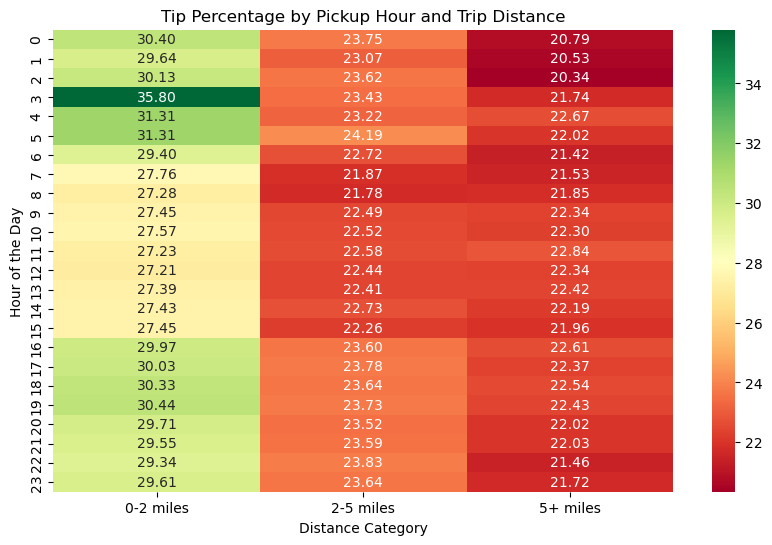

In [386]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
plt.figure(figsize=(10, 6))
# Calculate tip percentage
non_zero_df['tip_percentage'] = (non_zero_df['tip_amount'] / non_zero_df['fare_amount']) * 100
# Filter out invalid data (negative fares, zero fares, etc.)
non_zero_df = non_zero_df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0)]
#non_zero_df['distance_category'] = non_zero_df['trip_distance'].apply(categorize_distance) # Categorize distance
# Group by distance and compute avg tip percentage
tip_by_distance = non_zero_df.groupby('distance_category')['tip_percentage'].mean()
# Group by passenger count and compute average tip percentage
tip_by_passenger = non_zero_df.groupby('passenger_count')['tip_percentage'].mean()
# Group by hour and compute average tip percentage
tip_by_hour = non_zero_df.groupby('Pickup_hour')['tip_percentage'].mean()
# Pivot table for heatmap
tip_heatmap = non_zero_df.pivot_table(index='Pickup_hour', columns='distance_category', values='tip_percentage', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tip_heatmap, cmap="RdYlGn", annot=True, fmt=".2f")
plt.title("Tip Percentage by Pickup Hour and Trip Distance")
plt.ylabel("Hour of the Day")
plt.xlabel("Distance Category")
plt.show()

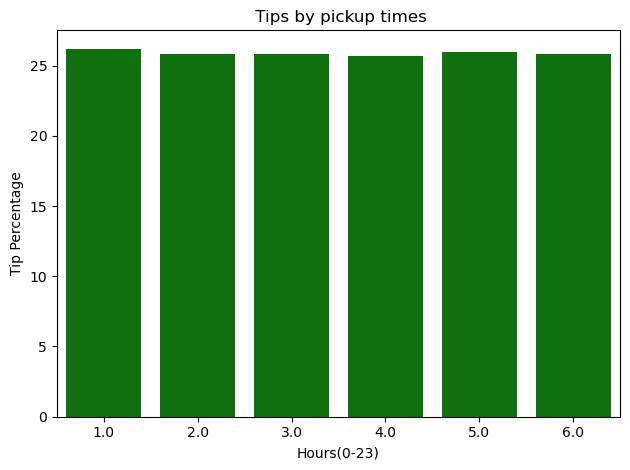

In [387]:
tip_by_passenger = non_zero_df.groupby('passenger_count')['tip_percentage'].mean().round(2).reset_index()
sns.barplot (x=tip_by_passenger.passenger_count,y=tip_by_passenger.tip_percentage, color='green')
plt.title(" Tips by pickup times")
plt.ylabel("Tip Percentage")
plt.xlabel("Hours(0-23)")
plt.tight_layout()
plt.show()



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

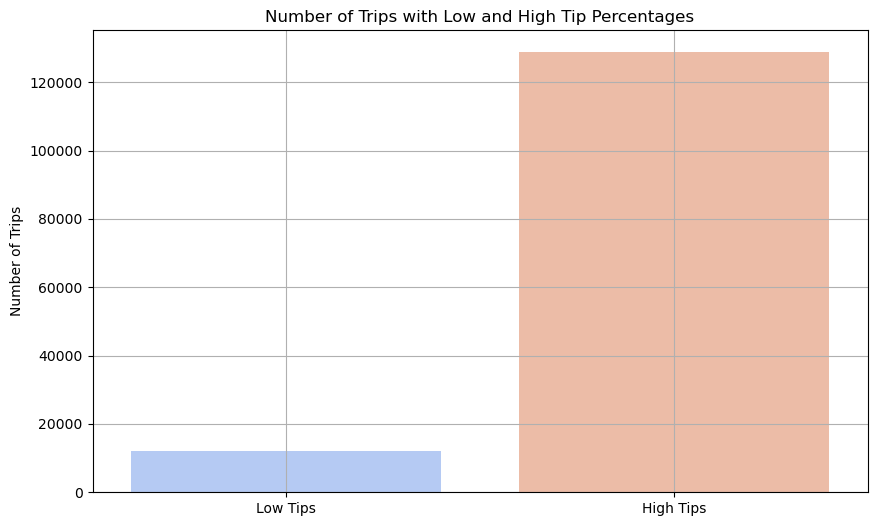

Low tip per trip: 12061
high tip per trip: 128741


In [388]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
low_tip_trips = non_zero_df[non_zero_df['tip_percentage'] < 10]
high_tip_trips = non_zero_df[non_zero_df['tip_percentage'] > 25]
plt.figure(figsize=(10, 6))
#Plot barplot for low and high tips with trips
sns.barplot(x=['Low Tips', 'High Tips'], y=[low_tip_trips.shape[0], high_tip_trips.shape[0]], palette="coolwarm")
plt.title('Number of Trips with Low and High Tip Percentages')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()
print('Low tip per trip:',low_tip_trips.shape[0])
print('high tip per trip:',high_tip_trips.shape[0])


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

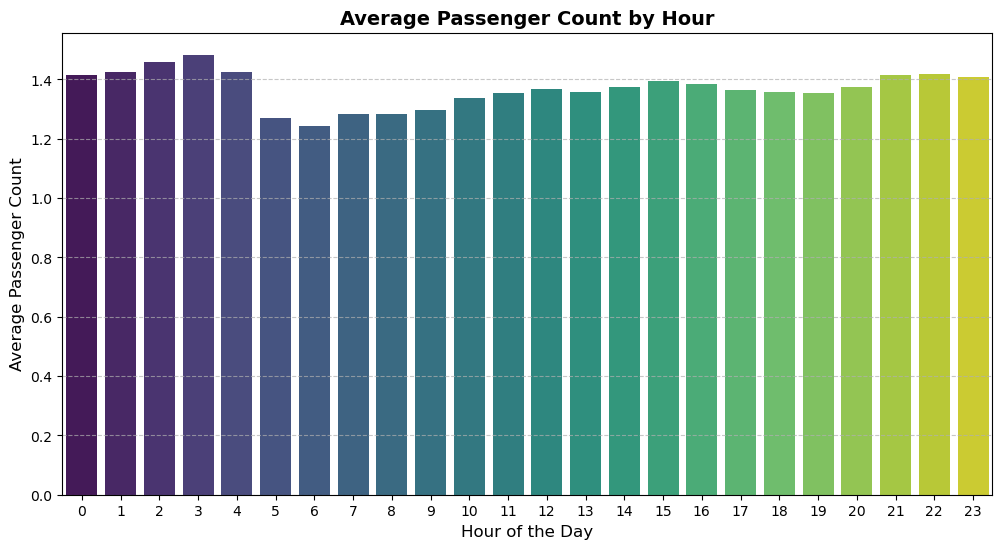

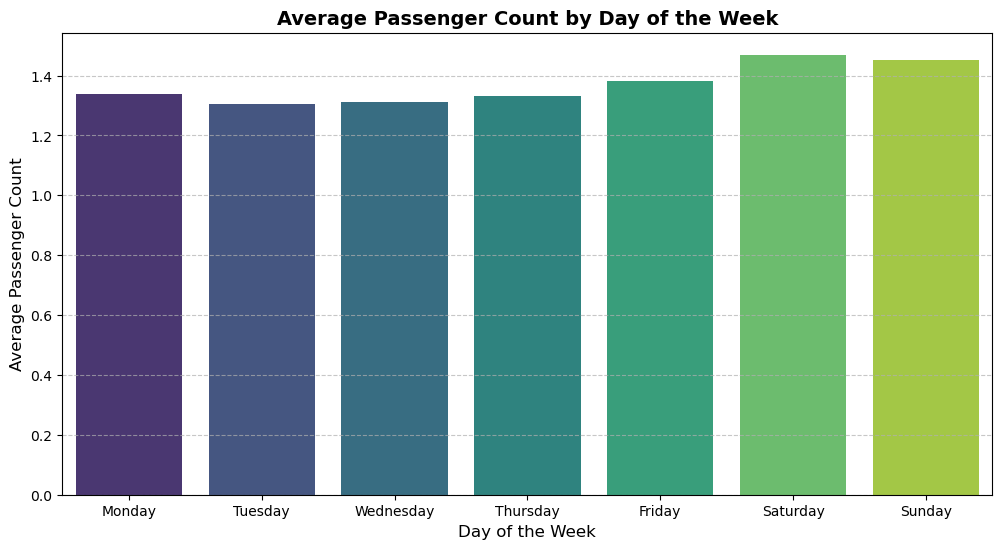

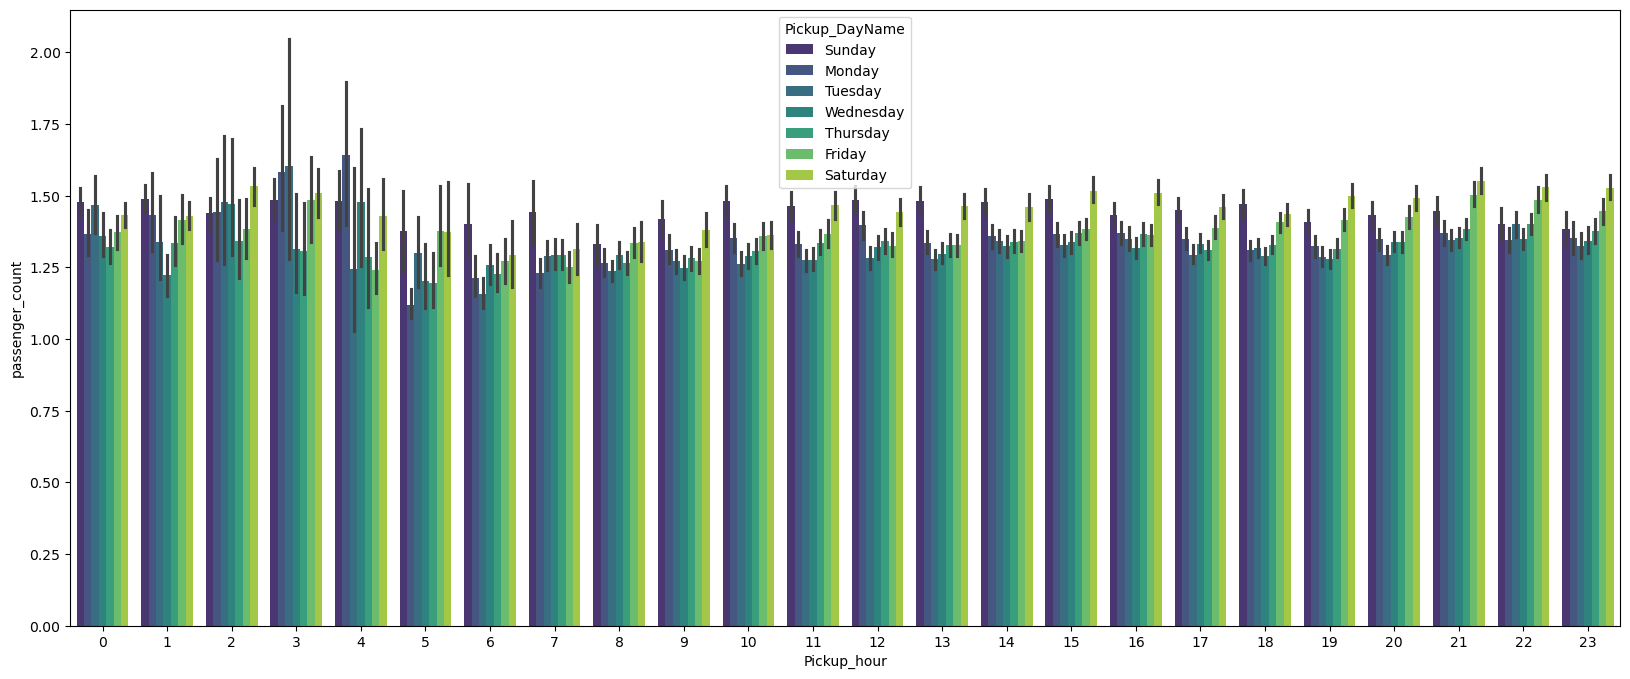

In [389]:
# Group data by Pickup_Hour and Day_of_Week to calculate the average passenger count
hourly_passenger_count = non_zero_df.groupby('Pickup_hour')['passenger_count'].mean().reset_index(name='Average_Passenger_Count')
daily_passenger_count = non_zero_df.groupby('Pickup_DayName')['passenger_count'].mean().reset_index(name='Average_Passenger_Count')

# Plot passenger count variation across hours
plt.figure(figsize=(12, 6))
sns.barplot(x='Pickup_hour', y='Average_Passenger_Count', data=hourly_passenger_count, palette='viridis')
plt.title('Average Passenger Count by Hour', fontsize=14, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Passenger Count', fontsize=12)
plt.xticks(range(0, 24, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot passenger count variation across days
plt.figure(figsize=(12, 6))
sns.barplot(x='Pickup_DayName', y='Average_Passenger_Count', data=daily_passenger_count, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Passenger Count by Day of the Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Passenger Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Combine both 
plt.figure(figsize=(20, 8))
sns.barplot(x='Pickup_hour', y='passenger_count', hue='Pickup_DayName',data=non_zero_df, palette='viridis')
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [ ]:
Trips_Count

Top 10 Zones by Average Passenger Count:
pickup_zone
Norwood                   6.00
Sunset Park West          2.25
Kew Gardens               2.17
Rosedale                  2.00
Middle Village            2.00
Woodhaven                 2.00
Green-Wood Cemetery       2.00
Crown Heights South       2.00
Inwood Hill Park          2.00
Mott Haven/Port Morris    1.83
Name: passenger_count, dtype: float64


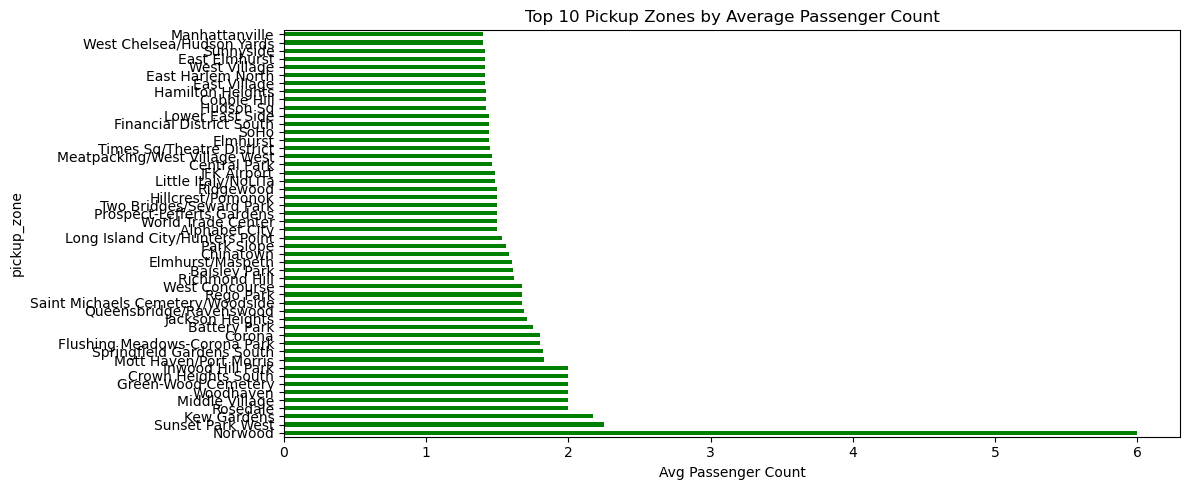

In [390]:
# How does passenger count vary across zones

passenger_by_zone = df_zones.groupby('pickup_zone')['passenger_count'].mean().sort_values(ascending=False).round(2)

# Show top 10 zones by average passenger count
print("Top 10 Zones by Average Passenger Count:")
print(passenger_by_zone.head(10))

passenger_by_zone.head(50).plot(kind='barh', figsize=(12, 5), color='green')
plt.title("Top 10 Pickup Zones by Average Passenger Count")
plt.xlabel("Avg Passenger Count")
plt.tight_layout()
plt.show()

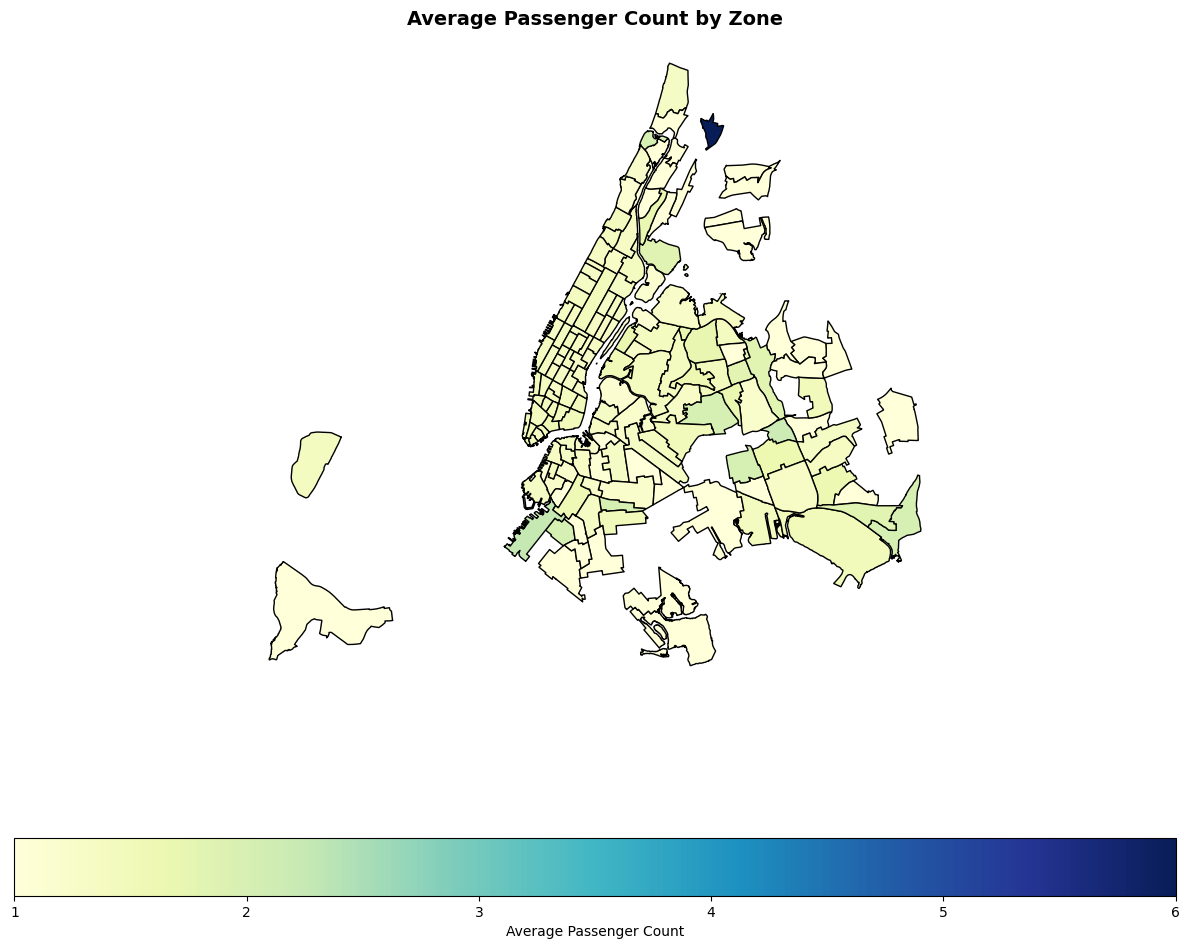

In [391]:
# Plot the average passenger count in each zone using GeoPandas map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# Plot the GeoDataFrame with average passenger count
zones_with_passenger_count.plot(
    column='Average_Passenger_Count', 
    cmap='YlGnBu', 
    legend=True, 
    legend_kwds={'label': "Average Passenger Count", 'orientation': "horizontal"},
    ax=ax,
    edgecolor='black'
)

# Add a title and remove axis
plt.title('Average Passenger Count by Zone', fontsize=14, fontweight='bold')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [392]:
trip_by_location = trips_zone_merge.groupby('LocationID').size().reset_index(name='trips')
trip_by_location

LocationID  trips
0           1.0      5
1           4.0    218
2           7.0     38
3           9.0      1
4          10.0     44
..          ...    ...
155       258.0      1
156       260.0     16
157       261.0   1090
158       262.0   3053
159       263.0   4436

[160 rows x 2 columns]

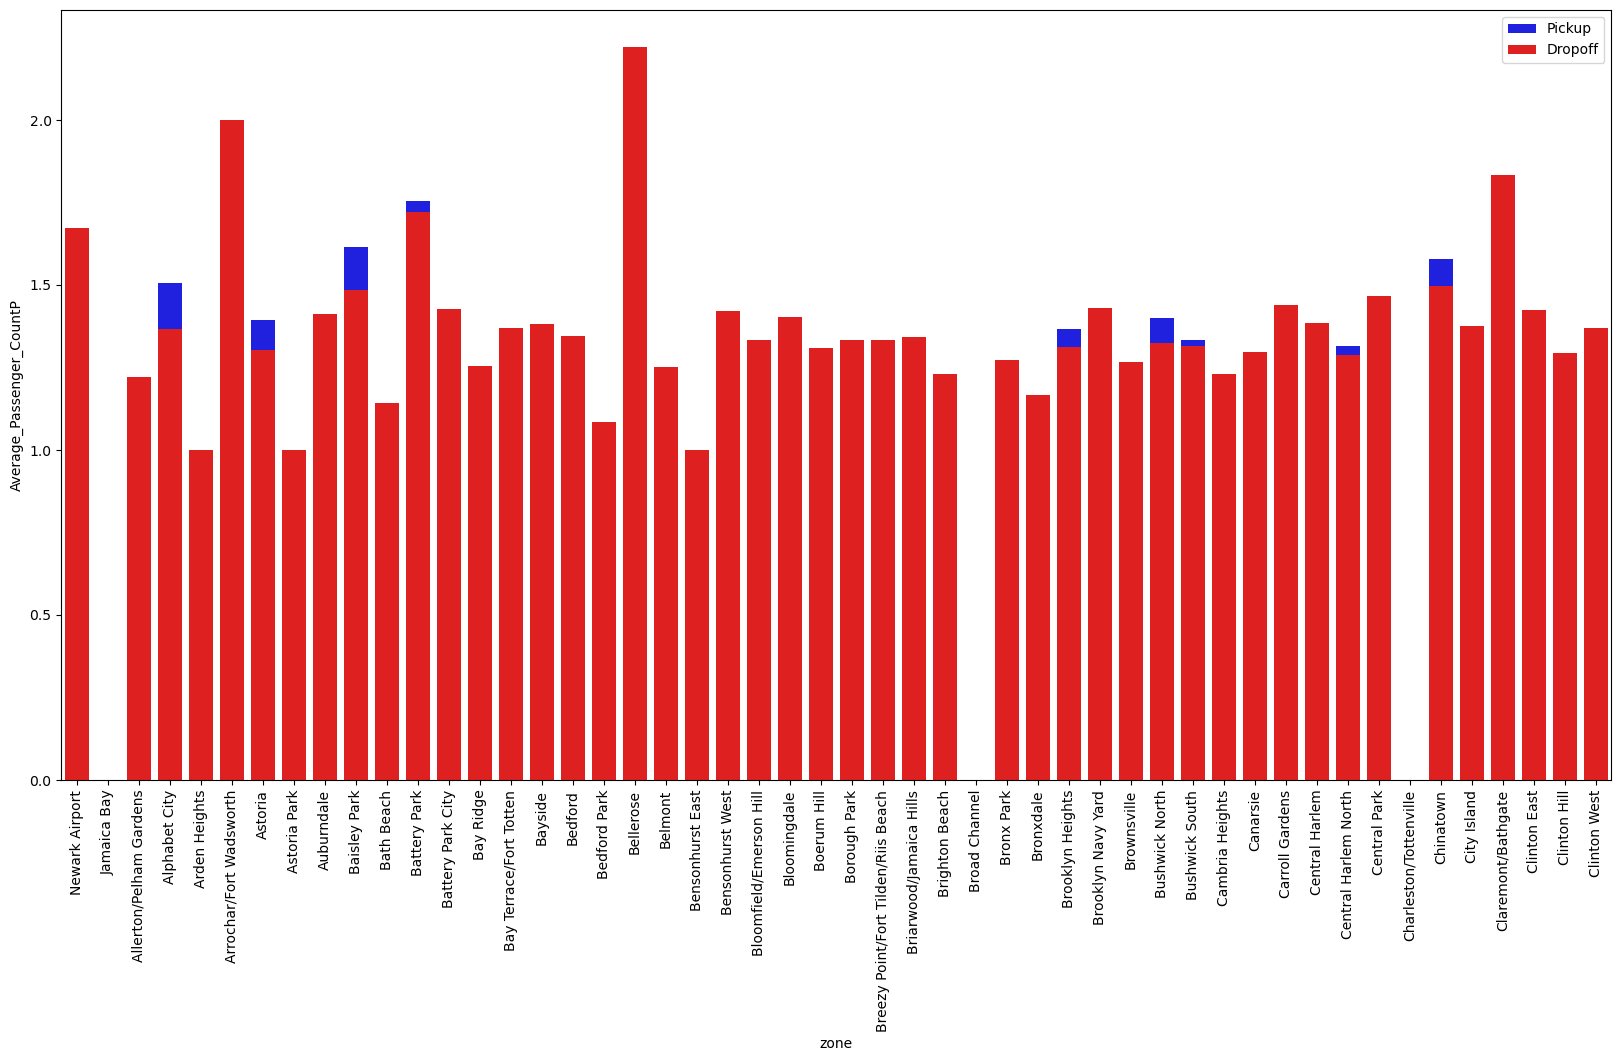

In [393]:


# Calculate the average passenger count for pickup and dropoff zones
avg_passenger_count_pickup = non_zero_df.groupby('PULocationID')['passenger_count'].mean().reset_index(name='Average_Passenger_CountP')
avg_passenger_count_dropoff = non_zero_df.groupby('DOLocationID')['passenger_count'].mean().reset_index(name='Average_Passenger_CountD')

# Merge the average passenger count data with the zones_with_trips GeoDataFrame
zones_trips = zones[['LocationID','zone']].merge(avg_passenger_count_pickup, left_on='LocationID', right_on='PULocationID', how='left')
zones_trips = zones_trips.merge(avg_passenger_count_dropoff, left_on='LocationID', right_on='DOLocationID', how='left')
zones_trips.head(2)

zones_trips.fillna(0, inplace=True)
#plot 
plt.figure(figsize=(20, 10))
sns.barplot(x='zone', y='Average_Passenger_CountP', data=zones_trips.head(50),color='blue',label='Pickup')
sns.barplot(x='zone', y='Average_Passenger_CountD', data=zones_trips.head(50),color='red',label='Dropoff')
plt.xticks(rotation=90,fontsize=10)
plt.show()


 extra: applied in 142,232 trips (49.73%)
 mta_tax: applied in 222,257 trips (77.71%)
 improvement_surcharge: applied in 223,517 trips (78.15%)
 congestion_surcharge: applied in 212,351 trips (74.24%)
 airport_fee: applied in 18,401 trips (6.43%)


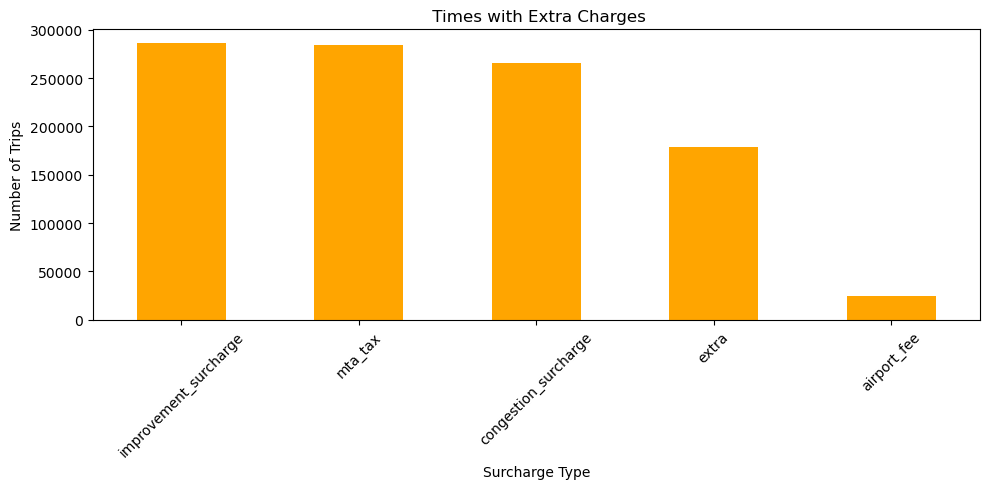

In [394]:
# How often is each surcharge applied?

surcharge_cols = ['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']
# Count non-zero values
for col in surcharge_cols:
    count_applied = (non_zero_df[col] > 0).sum()
    percentage = (count_applied / len(df)) * 100
    print(f" {col}: applied in {count_applied:,} trips ({percentage:.2f}%)")
    surcharge_counts = {col: (df[col] > 0).sum() for col in surcharge_cols}

surcharge_df = pd.DataFrame.from_dict(surcharge_counts, orient='index', columns=['count'])
surcharge_df['percentage'] = (surcharge_df['count'] / len(df)) * 100
surcharge_df = surcharge_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 5))
surcharge_df['count'].plot(kind='bar', color='orange')

plt.title(" Times with Extra Charges")
plt.xlabel("Surcharge Type")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**Recommendations by** <font color = green>Suyash Nagar</font> <br>
Use data driven approach,
- Demand based Dispatch 
  - Forecasting, using for example entertainment districts have higher demands on Friday and Saturday, compared to the rest of the days in week
- Use of real time traffic services, to avoid congestion and reroute to avoid        operational inefficiencies 
- Dynamic pricing to surge pricing during high demands to maximize revenue 
- Reduce response time to increase customer satisfaction and reduce competition vendors by distribution of vehicles across demand zones 
- Anticipate hotspot, for instance in areas with office or financial district position taxis to take advantage of office hours usually between 5 to 7 PM when people get off their jobs 



**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**Recommendations by** <font color = green>Suyash Nagar</font> <br>
- Rush Hours for peak zones
- Position taxis near transportation hubs like subways and bus terminals can capitalize on office commuters 
- On Fridays and Saturday’s taxis can be placed in places for nightlife such East side, Time Square or lower east side 
- Weekday vs Weekend, Monday to Friday focus on commercial and work commuters and then on weekends prioritize shopping complexes, malls and recreational areas such as restaurants 
- Avoid Taxi positions in low demand areas to avoid ideal time 
- Seasonal allocation, during rainy or snowy days, station additional cabs near residential areas and busy shopping districts where demand spikes


**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

**Recommendations by** <font color = green>Suyash Nagar</font> <br>

- Time and Zone based Pricing
- Increase surge during rush hours
- Another option is to offer discounts on non-peak hours to encourage ridership 
- Offer Carpool/ ride sharing services to increase profitability 
- Loyalty Programs, offer membership discounts or loyalty points to increase customer satisfaction and retain customer 
- Include real time analytics solutions to avoid waiting time such as rerouting drivers and avoiding congestion 
- Seasonal adjustments during holidays or harsh weather when demand is high
- introduce lower fares for underserved zones to promote usage in those areas.
- Leverage Machine learning to predict demand in areas, this will help in proactive dispatch of cabs 
- Partner with restaurants and tourisms services to offer bundled deals or doing advertisements for additional revenue 
